In [388]:
# importing libraries and packages
import snscrape.modules.twitter as sntwitter
import pandas as pd

# Creating list to append tweet data 
tweets_list10k = []
max_tweets = 10000
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:AmtrakAlerts').get_items()): #declare a username 
    if i>max_tweets: #number of tweets you want to scrape
        break
    tweets_list10k.append([tweet.date, tweet.id, tweet.content, tweet.user.username]) #declare the attributes to be returned
    
# Creating a dataframe from the tweets list above 
tweets_df10k = pd.DataFrame(tweets_list10k, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

In [389]:
tweets_df10k.to_csv('tweets10k.csv')

In [390]:
tweets_df1 = tweets_df10k

In [391]:
chars = set()
for t in tweets_df1['Text']:
    chars = chars.union(set(t))

In [392]:
chars

{'\n',
 ' ',
 '!',
 '#',
 '&',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\xa0',
 '–',
 '—',
 '’'}

In [393]:
import re
def tokenize(s):
    clean = re.sub('[.,]', '', s)
    return s.split()

In [394]:
tokens = set()
for t in tweets_df1['Text']:
    tokens = tokens.union(set(tokenize(t)))

In [395]:
len(tokens)

3662

In [204]:
import numpy as np
import re
from scipy import stats

def clean_text(s):
    cleaned = re.sub('[.,]','', s)
    cleaned = re.sub('[0-9][0-9]/[0-9][0-9]','DATE', cleaned)
    cleaned = re.sub('[0-9]','#', cleaned)
    return cleaned
# What data structure do I want?
# Each ngram should know the (n-1)grams it contains and the (n+1)grams that contain it

def ttest_lower(mean, n, p=0.95):
    vari = mean*(1-mean)
    interval = -stats.t.ppf((1-p)/2, n-1)*np.sqrt(vari/n)
    return max(0,mean-interval)


class Node:
    def __init__(self, data):
        self.data = data
        self.parents = []
        self.left = None
        self.right = None
        self.count = 0
        self.prob = None
        self.raw_prob = None
        self.fairscp = 0
        self.dominant = False
        self.dominant_thresh = 0
    def set_dominant(self):
        dom = True
        thresh = self.fairscp
        other = 0
        if len(self.data) <= 1:
            dom = False
            return
        if self.left is not None:
            other = max(other, self.left.fairscp)
            if self.left.fairscp > self.fairscp:
                dom = False
                return
        if self.right is not None:
            other  = max(other, self.right.fairscp)
            if self.right.fairscp > self.fairscp:
                dom = False
                return
#         print(self.parents)
        if max(0,0,*[n.fairscp for n in self.parents]) > self.fairscp:
            dom = False      
            return
        other = max(other, other, *[n.fairscp for n in self.parents])
        self.dominant = dom
#         if other == 0:
#             print('zero', self.data, *[n.fairscp if n is not None else -1 for n in [self.left, self.right, *self.parents]])
#             other = 1
        self.dominant_thresh = self.fairscp - other

class NgramGlue:
    def __init__(self, ends=True):
        self.ngrams = dict()
        self.node_dict = None
        self.ends = ends
        
    def add(self, text, n):
        # Text should be a list of strings
        # remove the following: ,.
        # 
        cleaned = clean_text(text)
        words = cleaned.split()
        if self.ends:
            words = ['@BOT@'] + words + ['@EOT@']

        for i in range(1,n+1):
            if i not in self.ngrams:
                self.ngrams[i] = dict()
            for j in range(len(words)-i+1):
                ng = tuple(words[j:j+i])
                self.ngrams[i][ng] = self.ngrams[i].get(ng, 0) + 1


    def build_tree(self):
        node_dict = {tuple(): Node(tuple())}
        node_dict[tuple()].prob = 1
        for key, ngs in self.ngrams.items():
            ng_ct = sum(ngs.values())
            for ng, ct in ngs.items():
                node = Node(ng)
                node.count = ct
                node.prob = ttest_lower(ct / ng_ct, ct, 0.25)
                node.raw_prob = ct / ng_ct
                node_dict[ng] = node

        for s, node in node_dict.items():
            if len(s) > 0:
                node.left = node_dict[s[:-1]]
                node.right = node_dict[s[1:]]
                node.left.parents.append(node)
                node.right.parents.append(node)

        for s, node in node_dict.items():
            if len(s) > 0:
                node.left = node_dict[s[:-1]]
                node.right = node_dict[s[1:]]
                node.left.parents.append(node)
                node.right.parents.append(node)
                if len(s) > 1:
                    priors = []
                    if node.count > 5:
                        for i in range(len(s)-1):
                            priors.append(node_dict[tuple(s[:i+1])].raw_prob * node_dict[tuple(s[i+1:])].raw_prob)
                        node.fairscp = ( node.raw_prob**2 ) / np.max(priors)
                
        self.node_dict = node_dict




## Some initial ngram work

In [10]:
ngg = NgramGlue()
for t in tweets_df1['Text']:
    ngg.add(t, 8)
ngg.build_tree()
for n in ngg.node_dict.values():
    n.set_dominant()

In [11]:
sorted([ (t,n.fairscp) for t,n in ngg.node_dict.items() if not np.isnan(n.fairscp)], key=lambda x: -x[1])

[(('Track', 'work', 'being', 'performed'), 1.1972206779531223),
 (('Missouri', 'River', 'Runner'), 1.1404564741858003),
 (('Jefferson', 'City', '(JEF)'), 1.1404564741858003),
 (('Oregon', 'City', '(ORC)'), 1.1404564741858003),
 (('Los', 'Angeles', '(LAX)'), 1.0897695197775426),
 (('Greensboro', '(GRO)'), 1.0888232402592612),
 (('York', '(NYP)'), 1.0888232402592612),
 (('Hamond-Whiting', '(HMI)'), 1.0888232402592612),
 (('Hermann', '(HEM)'), 1.0888232402592612),
 (('Norfolk', 'Southern'), 1.0888232402592612),
 (('Sanderson', '(SND)'), 1.0888232402592612),
 (('Barstow', '(BAR)'), 1.0888232402592612),
 (('Elko', '(ELK)'), 1.0888232402592612),
 (('Ontario', '(ONA)'), 1.0888232402592612),
 (('Coast', 'Starlight'), 1.088823240259261),
 (('Los', 'Angeles'), 1.088823240259261),
 (('Emeryville', '(EMY)'), 1.088823240259261),
 (('Missouri', 'River'), 1.088823240259261),
 (('River', 'Runner'), 1.088823240259261),
 (('Joliet', '(JOL)'), 1.088823240259261),
 (('Pere', 'Marquette'), 1.08882324025926

In [12]:
dominant_grams = [ (t,n) for t,n in ngg.node_dict.items() if n.dominant]
dominant_grams

[(('Lincoln', 'Service'), <__main__.Node at 0x1cc6b8bfe20>),
 (('Train', '###'), <__main__.Node at 0x1cc6b8bfee0>),
 (('is', 'currently'), <__main__.Node at 0x1cc6b8bffa0>),
 (('currently', 'operating'), <__main__.Node at 0x1cc6b8bfdc0>),
 (('operating', 'approximately'), <__main__.Node at 0x1cc6b8c20a0>),
 (('##mins', 'late'), <__main__.Node at 0x1cc6b8c2160>),
 (('due', 'to'), <__main__.Node at 0x1cc6b8c2220>),
 (('freight', 'train'), <__main__.Node at 0x1cc6b8c2340>),
 (('and', 'unforeseen'), <__main__.Node at 0x1cc6b8c2460>),
 (('unforeseen', 'track'), <__main__.Node at 0x1cc6b8c2040>),
 (('track', 'work'), <__main__.Node at 0x1cc6b8c2520>),
 (('work', 'north'), <__main__.Node at 0x1cc6b8c2580>),
 (('north', 'of'), <__main__.Node at 0x1cc6b8c24c0>),
 (('of', 'Carlinville'), <__main__.Node at 0x1cc6b8c2640>),
 (('Carlinville', '(CRV)'), <__main__.Node at 0x1cc6b8c26a0>),
 (('(CRV)', '@EOT@'), <__main__.Node at 0x1cc6b8c2700>),
 (('approaching', 'Michigan'), <__main__.Node at 0x1cc6b

In [13]:
print(ngg.node_dict[('Los',)].raw_prob * ngg.node_dict[('Angeles',)].raw_prob)
print(ngg.node_dict[('Los','Angeles')].raw_prob)

3.5068523895692182e-06
0.001954057926961657


In [14]:
from matplotlib import pyplot as plt

In [15]:
fairscps = [n.fairscp for n in ngg.node_dict.values() if not np.isnan(n.fairscp) and n.fairscp > 0]

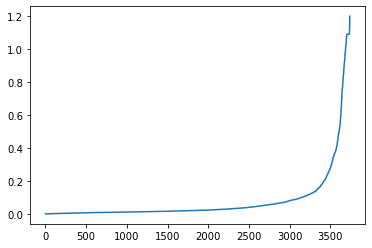

In [16]:
plt.plot(sorted(fairscps))
plt.show()

In [17]:
def elbow(data):
    xy = np.vstack([np.log(np.arange(len(data))+1), np.log(data)]).T
    xy -= xy[0]
    # send xy[-1] to [1,0]
    oz = xy[-1] / np.linalg.norm(xy[-1])
    A = np.vstack([oz, [-oz[1], oz[0]]]).T
    xy_rot = xy @ A
    return np.argmin(xy_rot[:,1])

In [21]:
elb = elbow(sorted(fairscps))
thresh = sorted(fairscps)[elb]
print(elb, thresh)

1745 0.01904549198599034


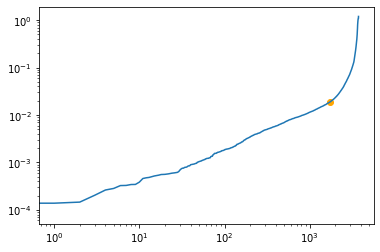

In [22]:
plt.plot(sorted(fairscps))
plt.scatter([elb],[thresh], color='orange')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [23]:
tokens = [ n for n in ngg.node_dict.values() if n.fairscp >= thresh]
sorted([(t.data, t.fairscp) for t in tokens], key=lambda x: -x[1])

[(('Track', 'work', 'being', 'performed'), 1.1972206779531223),
 (('Missouri', 'River', 'Runner'), 1.1404564741858003),
 (('Jefferson', 'City', '(JEF)'), 1.1404564741858003),
 (('Oregon', 'City', '(ORC)'), 1.1404564741858003),
 (('Los', 'Angeles', '(LAX)'), 1.0897695197775426),
 (('Greensboro', '(GRO)'), 1.0888232402592612),
 (('York', '(NYP)'), 1.0888232402592612),
 (('Hamond-Whiting', '(HMI)'), 1.0888232402592612),
 (('Hermann', '(HEM)'), 1.0888232402592612),
 (('Norfolk', 'Southern'), 1.0888232402592612),
 (('Sanderson', '(SND)'), 1.0888232402592612),
 (('Barstow', '(BAR)'), 1.0888232402592612),
 (('Elko', '(ELK)'), 1.0888232402592612),
 (('Ontario', '(ONA)'), 1.0888232402592612),
 (('Coast', 'Starlight'), 1.088823240259261),
 (('Los', 'Angeles'), 1.088823240259261),
 (('Emeryville', '(EMY)'), 1.088823240259261),
 (('Missouri', 'River'), 1.088823240259261),
 (('River', 'Runner'), 1.088823240259261),
 (('Joliet', '(JOL)'), 1.088823240259261),
 (('Pere', 'Marquette'), 1.08882324025926

In [24]:
# So now, given the probabilities, do the tokenization
# Taken from https://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words
words = [ n for n in ngg.node_dict.values() if n.fairscp >= thresh or len(n.data) == 1]
wordcost = dict((n.data, -np.log(n.raw_prob)) for i,n in enumerate(words))
maxword = max(len(x.data) for x in words)


def infer_spaces(s):
    """Uses dynamic programming to infer the location of spaces in a string
    without spaces."""

    # Find the best match for the i first characters, assuming cost has
    # been built for the i-1 first characters.
    # Returns a pair (match_cost, match_length).
    def best_match(i):
        candidates = enumerate(reversed(cost[max(0, i-maxword):i]))
        return min((c + wordcost.get(tuple(s[i-k-1:i]), 9e999), k+1) for k,c in candidates)

    # Build the cost array.
    cost = [0]
    for i in range(1,len(s)+1):
        c,k = best_match(i)
        cost.append(c)

    # Backtrack to recover the minimal-cost string.
    out = []
    i = len(s)
    while i>0:
        c,k = best_match(i)
        assert c == cost[i]
        out.append(s[i-k:i])
        i -= k

    return list(reversed(out))

In [25]:
text = tweets_df1['Text'][0]
cleaned = clean_text(text)
words = cleaned.split()
words = ['@BOT@'] + words + ['@EOT@']
infer_spaces(words)

[['@BOT@', 'Lincoln', 'Service', 'Train', '###', 'is'],
 ['currently',
  'operating',
  'approximately',
  '##mins',
  'late',
  'due',
  'to',
  'earlier'],
 ['freight', 'train', 'interference', 'and'],
 ['unforeseen'],
 ['track', 'work'],
 ['north', 'of'],
 ['Carlinville', '(CRV)'],
 ['@EOT@']]

In [26]:
tweets_tokenized = []
for text in tweets_df1['Text']:
    cleaned = re.sub('[.,]','', text)
    words = cleaned.split()
    words = ['@BOT@'] + words + ['@EOT@']
    tweets_tokenized.append(list(map(tuple,infer_spaces(words))))

In [27]:
token_ctr = {}
for t in tweets_tokenized:
    for term in t:
        token_ctr[term] = token_ctr.get(term,0) + 1

In [28]:
sorted(token_ctr.items(), key=lambda x: -x[1])

[(('is',), 1016),
 (('@EOT@',), 1001),
 (('currently',), 846),
 (('to',), 780),
 (('late',), 765),
 (('operating',), 737),
 (('due',), 630),
 (('on',), 594),
 (('approximately',), 496),
 (('which',), 408),
 (('departed',), 385),
 (('of',), 365),
 (('and',), 357),
 (('the',), 343),
 (('@BOT@',), 288),
 (('freight',), 249),
 (('approx',), 237),
 (('train',), 230),
 (('@BOT@', 'UPDATE:'), 228),
 (('stopped',), 180),
 (('interference',), 170),
 (('move',), 161),
 (('Train',), 150),
 (('(CHI)',), 148),
 (('Chicago',), 147),
 (('back',), 145),
 (('earlier',), 144),
 (('issues',), 142),
 (('minutes',), 128),
 (('rail',), 127),
 (('congestion',), 127),
 (('a',), 122),
 (('information',), 121),
 (('available',), 121),
 (('will',), 119),
 (('more',), 119),
 (('Updates',), 111),
 (('mechanical',), 104),
 (('30mins',), 103),
 (('New',), 103),
 (('route',), 101),
 (('along',), 98),
 (('min',), 97),
 (('from',), 94),
 (('30',), 94),
 (('east',), 93),
 (('as',), 90),
 (('@BOT@', 'Missouri', 'River', 

## Hidden Markov Modeling

In [29]:
## I think actually I want to learn an HMM that finds the structure in the Amtrak tweets
from hmmlearn.hmm import MultinomialHMM

model = MultinomialHMM(n_components=5)
sequences = []
seq_lengths = []
token_dict = {}
for words in tweets_tokenized:
    for w in words:
        token_dict[w] = token_dict.get(w,len(token_dict))
        sequences.append(token_dict[w])
    seq_lengths.append(len(words))
    
sequences = np.array(sequences)    
model.fit(sequences.reshape(-1,1), seq_lengths)

MultinomialHMM(n_components=5,
               random_state=RandomState(MT19937) at 0x1CC5A5A2D40)

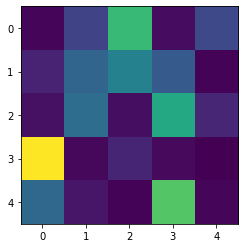

In [30]:
plt.imshow(model.transmat_)

<BarContainer object of 5 artists>

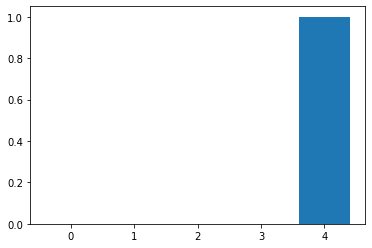

In [31]:
plt.bar(*np.transpose(list(enumerate(model.startprob_))))

In [32]:
token_lookup = [0] * len(token_dict)
for t,i in token_dict.items():
    token_lookup[i] = t


In [33]:
def examine_emissions(state, n=20):
    return sorted([ (token_lookup[i], p) for i,p in enumerate(model.emissionprob_[state,:])], key=lambda x: -x[1])[:n]

[(('approximately',), 0.11964642481206761), (('@BOT@',), 0.11295239026033145), (('@BOT@', 'UPDATE:'), 0.08942064228942907), (('is',), 0.0815368944386818), (('approx',), 0.0497746104483121), (('and',), 0.038311780759614104), (('@BOT@', 'Missouri', 'River', 'Runner', 'Train'), 0.0345132303573235), (('@BOT@', 'Wolverine', 'Train'), 0.03372883875829342), (('back',), 0.029241482696742985), (('@BOT@', 'Amtrak', 'Cascades', 'Train'), 0.027061510166537746), (('follow',), 0.021517176190275454), (('@BOT@', 'Lincoln', 'Service', 'Train'), 0.01960978997575199), (('earlier',), 0.019266682530654968), (('@BOT@', 'Saluki', 'Train'), 0.01804100677769183), (('late',), 0.016435723750941152), (('along',), 0.015822496969926294), (('south',), 0.015193175476025776), (('update',), 0.014466802684449621), (('east',), 0.012491789771918642), (('@BOT@', 'California', 'Zephyr', 'Train'), 0.012158069784966233)]


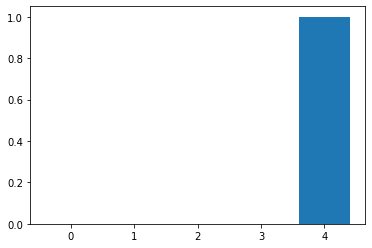

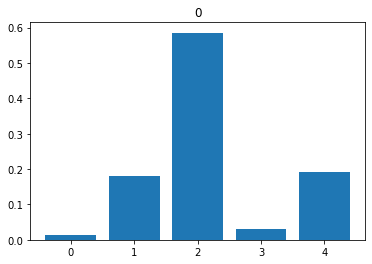

[(('operating',), 0.13551920166698722), (('which',), 0.07158032077807423), (('train',), 0.0413189817217443), (('due',), 0.039894972691017376), (('stopped',), 0.02741443086454891), (('the',), 0.027383151941734445), (('of',), 0.02732215220822813), (('more',), 0.02204346618606448), (('minutes',), 0.020542337726728088), (('congestion',), 0.019284458700002734), (('available',), 0.018634299301644466), (('issues',), 0.017842009318849272), (('Train',), 0.015352340666752801), (('@EOT@',), 0.014343985950866946), (('min',), 0.013501714326331005), (('will',), 0.013416818991766706), (('route',), 0.012512311212695412), (('30mins',), 0.01018059952983585), (('York',), 0.00977602891788473), (('hr',), 0.0097027669193423)]
--


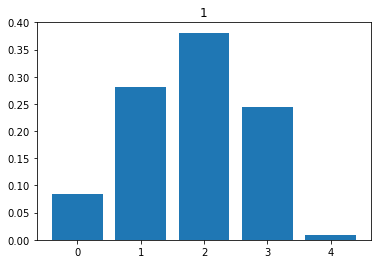

[(('due',), 0.11190609487584595), (('@EOT@',), 0.07080286891432652), (('late',), 0.07064624425314403), (('Chicago',), 0.0327312673233847), (('and',), 0.031099940841865494), (('to',), 0.03010980716607809), (('the',), 0.022481251131837687), (('Updates',), 0.02019438585666219), (('approximately',), 0.019555197443559255), (('a',), 0.018332190759632716), (('is',), 0.01770271425734253), (('earlier',), 0.017358917487611515), (('back',), 0.015305767378248764), (('between',), 0.011286100879948566), (('from',), 0.011115212898420648), (('come',), 0.010217191585502805), (('30mins',), 0.009588306407757652), (('into',), 0.009196906091458477), (('Seattle',), 0.009020611403290342), (('delayed',), 0.009007089197632554)]
--


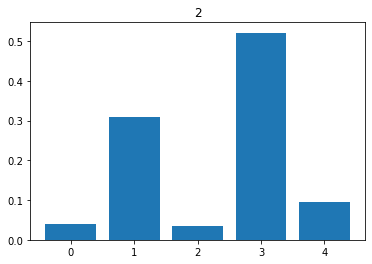

[(('is',), 0.14871556110204348), (('to',), 0.133216050264723), (('late',), 0.0863654679952444), (('departed',), 0.07053861378883977), (('@EOT@',), 0.058798012559024594), (('(CHI)',), 0.025888991750348662), (('interference',), 0.025520683630106157), (('and',), 0.025068776782126722), (('approximately',), 0.024158650345400195), (('move',), 0.02059617290908603), (('information',), 0.02010860585344787), (('approx',), 0.0189801833935993), (('will',), 0.009299918958325819), (('in',), 0.008703960244652661), (('issues',), 0.008239583974617395), (('along',), 0.007471503952483266), (('City',), 0.007216149428834054), (('disabled',), 0.007206728375498339), (('(NYP)',), 0.007046993513772092), (('ahead',), 0.006974746594254117)]
--


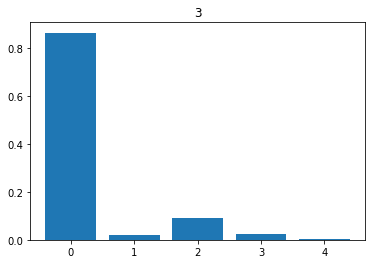

[(('currently',), 0.16415545528702705), (('on',), 0.10436507114409684), (('@EOT@',), 0.06984702736820496), (('freight',), 0.04549011525550363), (('of',), 0.03259976043066544), (('rail',), 0.022275136625750168), (('New',), 0.019423101061072683), (('as',), 0.01668445226496605), (('mechanical',), 0.016310167618500716), (('becomes',), 0.015643846991888317), (('the',), 0.014905753586938401), (('We',), 0.014130079515613713), (('30',), 0.014052659074355196), (('1hr',), 0.013595528466433842), (('1',), 0.010402491598707132), (('speed',), 0.010278783229852068), (('its',), 0.009783585086474762), (('2',), 0.00954528685070161), (('Los',), 0.008564014582143635), (('3',), 0.008411106962794963)]
--


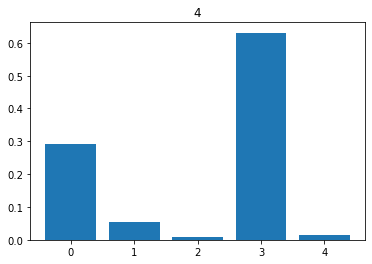

[(('approximately',), 0.11964642481206761), (('@BOT@',), 0.11295239026033145), (('@BOT@', 'UPDATE:'), 0.08942064228942907), (('is',), 0.0815368944386818), (('approx',), 0.0497746104483121), (('and',), 0.038311780759614104), (('@BOT@', 'Missouri', 'River', 'Runner', 'Train'), 0.0345132303573235), (('@BOT@', 'Wolverine', 'Train'), 0.03372883875829342), (('back',), 0.029241482696742985), (('@BOT@', 'Amtrak', 'Cascades', 'Train'), 0.027061510166537746), (('follow',), 0.021517176190275454), (('@BOT@', 'Lincoln', 'Service', 'Train'), 0.01960978997575199), (('earlier',), 0.019266682530654968), (('@BOT@', 'Saluki', 'Train'), 0.01804100677769183), (('late',), 0.016435723750941152), (('along',), 0.015822496969926294), (('south',), 0.015193175476025776), (('update',), 0.014466802684449621), (('east',), 0.012491789771918642), (('@BOT@', 'California', 'Zephyr', 'Train'), 0.012158069784966233)]
--


[(('approximately',), 0.11964642481206761),
 (('@BOT@',), 0.11295239026033145),
 (('@BOT@', 'UPDATE:'), 0.08942064228942907),
 (('is',), 0.0815368944386818),
 (('approx',), 0.0497746104483121),
 (('and',), 0.038311780759614104),
 (('@BOT@', 'Missouri', 'River', 'Runner', 'Train'), 0.0345132303573235),
 (('@BOT@', 'Wolverine', 'Train'), 0.03372883875829342),
 (('back',), 0.029241482696742985),
 (('@BOT@', 'Amtrak', 'Cascades', 'Train'), 0.027061510166537746),
 (('follow',), 0.021517176190275454),
 (('@BOT@', 'Lincoln', 'Service', 'Train'), 0.01960978997575199),
 (('earlier',), 0.019266682530654968),
 (('@BOT@', 'Saluki', 'Train'), 0.01804100677769183),
 (('late',), 0.016435723750941152),
 (('along',), 0.015822496969926294),
 (('south',), 0.015193175476025776),
 (('update',), 0.014466802684449621),
 (('east',), 0.012491789771918642),
 (('@BOT@', 'California', 'Zephyr', 'Train'), 0.012158069784966233)]

In [34]:
plt.bar(*np.transpose(list(enumerate(model.startprob_))))
print(examine_emissions(np.argmax(model.startprob_)))
plt.show()
for i in range(len(model.transmat_)):
    plt.bar(*np.transpose(list(enumerate(model.transmat_[i]))))
    plt.title(i)
    plt.show()
    print(examine_emissions(i))
    print('--')

examine_emissions(4)

In [35]:
hmm_terms = []
for words in tweets_tokenized:
    sequence = np.array([token_dict[w] for w in words])
    state_seq = model.decode(sequence.reshape(-1,1))[1]
    terms = []
    prev_state = -1
    term = []
    for word, state in zip(words, state_seq):
        if state == prev_state:
            term.append(word)
        else:
            terms.append(tuple(term))
            term = [word]
            prev_state = state
    terms.append(tuple(term))
    hmm_terms.append(terms)

In [36]:
token_ctr = {}
for t in hmm_terms:
    for term in t:
        token_ctr[term] = token_ctr.get(term,0) + 1
sorted(token_ctr.items(), key=lambda x: -x[1])        

[((('is',),), 1010),
 ((), 1001),
 ((('@EOT@',),), 1001),
 ((('currently',),), 843),
 ((('to',),), 779),
 ((('late',),), 760),
 ((('operating',),), 735),
 ((('due',),), 593),
 ((('on',),), 589),
 ((('approximately',),), 496),
 ((('which',),), 392),
 ((('departed',),), 384),
 ((('of',),), 364),
 ((('and',),), 317),
 ((('the',),), 316),
 ((('@BOT@',),), 288),
 ((('freight',),), 245),
 ((('approx',),), 237),
 ((('train',),), 230),
 ((('@BOT@', 'UPDATE:'),), 217),
 ((('stopped',),), 180),
 ((('interference',),), 170),
 ((('move',),), 161),
 ((('Train',),), 150),
 ((('(CHI)',),), 148),
 ((('back',),), 142),
 ((('issues',),), 131),
 ((('minutes',),), 128),
 ((('rail',),), 127),
 ((('congestion',),), 127),
 ((('earlier',),), 124),
 ((('information',),), 121),
 ((('available',),), 121),
 ((('will',),), 119),
 ((('more',),), 119),
 ((('30mins',),), 103),
 ((('New',),), 103),
 ((('a',),), 103),
 ((('route',),), 101),
 ((('mechanical',),), 100),
 ((('Chicago',),), 100),
 ((('along',),), 98),
 (((

In [37]:
state_seq

array([4, 0, 2, 3, 0, 4, 3, 0, 2, 1, 2, 3, 0, 4, 3, 0, 4, 3])

In [38]:
due_tweets = [t for t in tweets_df1['Text'] if 'due' in t]
print('\n'.join(due_tweets))

Lincoln Service Train 302 is currently operating approximately 50mins late due to earlier freight train interference and unforeseen track work north of Carlinville (CRV).
Carolinian Train 80 is currently stopped east of Greensboro (GRO) due to a vehicle on the tracks. Updates to come.
Wolverine Train 351 is currently operating approximately 30mins late due to boarding delays, freight train interference, and mechanical issues along the route.
Coast Starlight Train 14 which departed from Los Angeles (LAX) on 11/22 is currently operating approximately 4hrs 20mins late due to earlier law enforcement personnel near the tracks and mechanical issues between Emeryville (EMY) and Davis (DAV).
Sunset Limited Train 1 which departed from New Orleans (NOL) on 11/21 is currently operating approximately 5hrs 10mins late due to earlier freight train interference and mechanical issues west of Houston (HOS).
Wolverine Train 355 is currently operating approx. 35min late due toe earlier rail congestion an

In [39]:
reasons = {}
for tweet in due_tweets:
    s = re.findall('due[^.]+', tweet)[0]
    reasons[s] = reasons.get(s,0) + 1

In [40]:
sorted(reasons.items(), key=lambda x: -x[1])

[('due to mechanical issues', 30),
 ('due to a disabled freight train blocking the tracks', 20),
 ('due to freight train interference', 19),
 ('due to rail congestion along the route', 14),
 ('due to a disabled freight train ahead', 14),
 ('due to disabled freight train in its path', 12),
 ('due to a vehicle incident', 9),
 ('due to a trespasser incident', 9),
 ('due to freight train interference along its route', 8),
 ('due to the late arrival of inbound equipment', 7),
 ('due to freight interference and speed restrictions along the route', 6),
 ('due to earlier freight train interference', 5),
 ('due to weather-related delays in the area', 5),
 ('due to a vehicle on the tracks', 4),
 ('due to a disabled freight train', 4),
 ('due to freight train interference between Lee’s Summit (LEE) and Warrensburg (WAR)',
  4),
 ('due to mechanical problems', 4),
 ('due to a disabled freight ahead', 4),
 ('due to rail congestion', 4),
 ('due to equipment issues which delayed its departure from Ch

In [41]:
dngg = NgramGlue()
for t,ct in reasons.items():
    for _ in range(ct):
        dngg.add(t, 8)
dngg.build_tree()
for n in dngg.node_dict.values():
    n.set_dominant()
    
sorted([ (t,n.fairscp) for t,n in dngg.node_dict.items() if not np.isnan(n.fairscp)], key=lambda x: -x[1])    

[(('which', 'delayed', 'its', 'departure', 'from'), 1.6246960997051818),
 (('which', 'delayed', 'its', 'departure'), 1.407202167084119),
 (('Fort', 'Worth', '(FTW)'), 1.3628591556127823),
 (('Jefferson', 'City', '(JEF)'), 1.362859155612782),
 (('@BOT@', 'due', 'to'), 1.343327934276134),
 (('Hermann', '(HEM)'), 1.212497235276039),
 (('Warrensburg', '(WAR)'), 1.212497235276039),
 (('Norfolk', 'Southern'), 1.212497235276039),
 (('Fort', 'Worth'), 1.212497235276039),
 (('Worth', '(FTW)'), 1.212497235276039),
 (('Elko', '(ELK)'), 1.212497235276039),
 (('Sedalia', '(SED)'), 1.2124972352760388),
 (('Chicago', '(CHI)'), 1.2124972352760386),
 (('Centralia', '(CTL)'), 1.2124972352760386),
 (('Eugene', '(EUG)'), 1.2124972352760386),
 (('Kankakee', '(KKI)'), 1.2124972352760386),
 (('due', 'to'), 1.202877310880821),
 (('@BOT@', 'due'), 1.2009496425591246),
 (('rail', 'congestion'), 1.1934779656049601),
 (('Lee’s', 'Summit', '(LEE)', 'and', 'Warrensburg', '(WAR)'),
  1.179973394043398),
 (('speed', 

## PCA and clustering

In [42]:
## What if we just do regular clustering?
reason_dict = {}
for t in reasons:
    for w in clean_text(t).split():
        reason_dict[w] = reason_dict.get(w,len(reason_dict))
        
vectors = np.zeros((sum(reasons.values()), len(reason_dict)))
for i,t in enumerate(due_tweets):
    for w in clean_text(re.findall('due[^.]+', t)[0]).split():
        vectors[i,reason_dict[w]] += 1

vectors_mean = np.mean(vectors, 0)
vectors_c = vectors - vectors_mean
u,s,vt = np.linalg.svd(vectors_c)

In [43]:
def bar(x):
    plt.bar(*np.transpose(list(enumerate(x))))

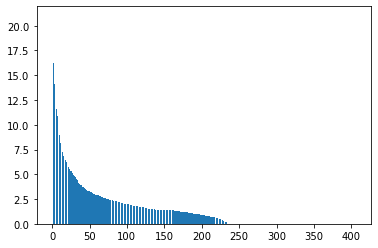

In [44]:
bar(s)

In [45]:
reason_list = [0]*len(reason_dict)
for t,i in reason_dict.items():
    reason_list[i]=t
def analyze_vector(v, n=10):
    best= sorted([(reason_list[i], val) for i,val in enumerate(v)], key=lambda x: -abs(x[1]))[:n]
    for w,s in best:
        print(w,': ', s)

In [46]:
for i in range(10):
    print(i)
    analyze_vector(vt[i],5)
    print('--')

0
freight :  -0.47714961201444506
train :  -0.4732570822656737
congestion :  0.31546132395312687
rail :  0.31437291918834287
interference :  -0.3024679568831268
--
1
and :  -0.4637662320404649
interference :  -0.3638171023262173
freight :  -0.3167787480885031
route :  -0.30967220276686364
along :  -0.3052269619321011
--
2
the :  -0.47827092834873247
of :  0.37549662183816057
a :  -0.3294168504764218
earlier :  0.2972804915872797
disabled :  -0.2615488204898197
--
3
issues :  0.5410408290185537
mechanical :  0.408012973694966
of :  -0.40034697587960844
rail :  -0.34731182714339826
congestion :  -0.3447527688412962
--
4
of :  -0.41474360651590936
between :  0.39214101686210484
and :  0.30851515330359314
the :  -0.3001776898098489
route :  -0.2197356796157908
--
5
earlier :  0.43346265401057166
issues :  0.312829354644683
tracks :  0.2909736181713045
the :  0.26871827105026064
of :  0.26425002457520885
--
6
and :  0.3981720546177456
between :  0.32792153810611696
rail :  -0.27801297853457

In [47]:
svalrat = np.cumsum(s**2)/np.sum(s**2)
sdim = np.argmax(svalrat > 0.9)
vectors_d = u[:,:sdim]*s[:sdim]

In [48]:
tfidf = (vectors / vectors.sum(0))

In [49]:
from sklearn.cluster import AgglomerativeClustering

10


<ipython-input-17-1cad6de30393>:2: RuntimeWarning: divide by zero encountered in log
  xy = np.vstack([np.log(np.arange(len(data))+1), np.log(data)]).T
<ipython-input-17-1cad6de30393>:3: RuntimeWarning: invalid value encountered in subtract
  xy -= xy[0]
<ipython-input-17-1cad6de30393>:5: RuntimeWarning: invalid value encountered in true_divide
  oz = xy[-1] / np.linalg.norm(xy[-1])
<ipython-input-17-1cad6de30393>:7: RuntimeWarning: invalid value encountered in matmul
  xy_rot = xy @ A


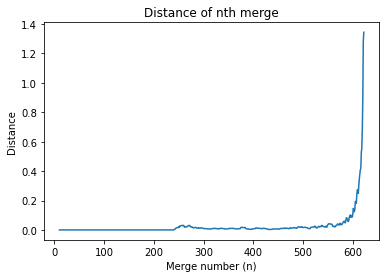

Cluster  0 Members:  74
	Mean:    1.524913790797664
	Median:  1.2789574603000742

Cluster  1 Members:  124
	Mean:    1.7196335191521408
	Median:  1.7602997664871338

Cluster  2 Members:  30
	Mean:    1.8392880890990544
	Median:  1.6782856942332378

Cluster  3 Members:  143
	Mean:    1.6723577750833767
	Median:  1.7228558040007473

Cluster  4 Members:  67
	Mean:    2.025409240546089
	Median:  1.8686799204084525

Cluster  5 Members:  25
	Mean:    1.3724120240074489
	Median:  1.5990677938686888

Cluster  6 Members:  49
	Mean:    2.2108043251469427
	Median:  2.228790388577351

Cluster  7 Members:  48
	Mean:    1.5753877015260105
	Median:  1.5134320469000722

Cluster  8 Members:  53
	Mean:    1.4403110701709412
	Median:  1.4343443283046913

Cluster  9 Members:  11
	Mean:    1.2978729543262102
	Median:  1.071288743922261

Cluster  0 Size:  74
due :  1.0
to :  1.0
disabled :  0.972972972972973
freight :  0.9459459459459459
train :  0.9324324324324325
a :  0.7162162162162162
the :  0.432432432

In [50]:

aggc = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
aggc.fit(vectors_d)

ddists = aggc.distances_[1:] - aggc.distances_[:-1]

n = 10
cddists = np.convolve(aggc.distances_[1:] - aggc.distances_[:-1], np.ones(n), 'valid')/n
sddists = sorted(cddists)
ebow = elbow(sddists)
plt.plot(np.arange(len(aggc.distances_))[n:], cddists)
plt.title('Distance of nth merge')
plt.xlabel('Merge number (n)')
plt.ylabel('Distance')
idx = np.argmax(cddists[::-1] < sddists[ebow])+n

print(idx)
plt.plot([len(cddists) - idx],[sddists[ebow]], color='red')
plt.show()

aggc = AgglomerativeClustering(idx)
aggc.fit(vectors_d)

# Let's look at how tight the clusters
for i in range(aggc.n_clusters):
    members = np.argwhere(aggc.labels_ == i).flatten()
    dists = np.linalg.norm(vectors_d[members] - np.mean(vectors_d[members],axis=0), axis=1)
    print('Cluster ',i, 'Members: ', len(members))
    print('\tMean:   ', np.mean(dists))
    print('\tMedian: ', np.median(dists))
    print()
    
    
# Let's look what the clusters mean
for i in range(aggc.n_clusters):
    members = np.argwhere(aggc.labels_ == i).reshape(-1)
    print('Cluster ',i, 'Size: ', len(members))
    analyze_vector(np.mean(vectors[members],axis=0))
    print()

In [51]:
tweets_df1

,Datetime,Tweet Id,Text,Username
0,2021-11-23 15:18:09+00:00,1463164975673925644,Lincoln Service Train 302 is currently operati...,AmtrakAlerts
1,2021-11-23 15:00:07+00:00,1463160438980595728,Wolverine Train 350 is currently operating app...,AmtrakAlerts
2,2021-11-23 14:25:39+00:00,1463151765453422604,Carolinian Train 80 is currently stopped east ...,AmtrakAlerts
3,2021-11-23 13:27:05+00:00,1463137024249053191,Wolverine Train 351 is currently operating app...,AmtrakAlerts
4,2021-11-23 12:15:39+00:00,1463119051115401220,Coast Starlight Train 14 which departed from L...,AmtrakAlerts
...,...,...,...,...
996,2021-10-12 21:28:54+00:00,1448037989356015616,UPDATE: Cascades Train 503 is back on the move...,AmtrakAlerts
997,2021-10-12 21:08:43+00:00,1448032908841791490,Cascades Train 503 is currently stopped south ...,AmtrakAlerts
998,2021-10-12 16:36:40+00:00,1447964446220070917,UPDATE: Train 500 is back on the move operatin...,AmtrakAlerts
999,2021-10-12 16:28:21+00:00,1447962353451126786,Saluki Train 390 is currently operating approx...,AmtrakAlerts


## Regular pattern analysis

In [396]:
train_infos = []
for i,t in tweets_df1.iterrows():
    date = t['Datetime']
    if 'Train ' in t['Text']:
        info = re.findall('(?:[A-Z][a-z]+ )?(?:[A-Z][a-z]+ )?(?:[A-Z][a-z]+ )?Train [0-9]*', t['Text'])[0]
    else:
        info=None
    depart = re.findall('which [^.]*depart[^.]*[0-9]+/[0-9]+', t['Text'])
    if len(depart) > 0:
        note = depart[0]
    else:
        note = None
    if 'due to' in t['Text']:
        reason = re.findall('due to[^.]*', t['Text'])[-1]
    else:
        reason = None
    delay = re.findall('(?:([0-9]+) ?(?:h(?:(?:ou)?rs?)?))? ?(?:and )?(?:([0-9]+) ?(?:m(?:in(?:ute)?s?)?))? late', t['Text'])
    if len(delay) > 0 and (len(delay[0][0]) > 0 or len(delay[0][1]) > 0):
        time = int(delay[0][0] or 0) * 60 + int(delay[0][1] or 0)
        if time == 0:
            print('\t', delay)
        delay = time
        
    else:
        delay = None
    train_infos.append( (date, info, note, reason, delay, t['Text']))

In [397]:
train_infos

[(Timestamp('2021-11-25 02:50:15+0000', tz='UTC'),
  'Southwest Chief Train 3',
  'which departed Chicago (CHI) on 11/23',
  None,
  75,
  'UPDATE: Southwest Chief Train 3 which departed Chicago (CHI) on 11/23 is back on the move and currently operating approximately 1hr 15mins late.'),
 (Timestamp('2021-11-25 02:45:51+0000', tz='UTC'),
  'Silver Meteor Train 97',
  'which departed New York (NYP) on 11/24',
  'due to earlier mechanical issues and rail congestion along its route',
  120,
  'Silver Meteor Train 97 which departed New York (NYP) on 11/24, is currently operating approximately 2hrs late due to earlier mechanical issues and rail congestion along its route.'),
 (Timestamp('2021-11-25 02:09:46+0000', tz='UTC'),
  'Southwest Chief Train 3',
  'which departed Chicago (CHI) on 11/23',
  'due to fire department personnel activity',
  None,
  'Southwest Chief Train 3 which departed Chicago (CHI) on 11/23 is stopped outside Gallup (GLP) due to fire department personnel activity. Upda

In [403]:
unlabeled = [t for t in train_infos if t[1] is None]
print(len(unlabeled))
for t in unlabeled:
    print(t[-1])
    print('--')

206
Sunset Limited Train1 which departed New Orleans (NOL) on 11/10 is currently stopped east of Sanderson (SND) due to a disabled freight train blocking the tracks. Updates to come.
--
Lincoln Service 305 is currently operating approximately 30mins late into Joliet (JOL).
--
Service Advisory Reminder: Coast Starlight and Southwest Chief schedules will be adjusted today as outlined.

https://t.co/V7ApRe9okS https://t.co/nyCRNGPLjQ
--
Service Advisory Reminder: Coast Starlight and Southwest Chief schedules will be adjusted effective October 25 as outlined.

https://t.co/V7ApRe9okS https://t.co/6z5NDcpQw5
--
Service Advisory Reminder: To accommodate the Metrolink-SCRRA track work on October 23 and 24, the Pacific Surfliner and Coast Starlight service will be adjusted as outlined.  
https://t.co/PlwTzqpszH https://t.co/7Xg9lKFCto
--
Service Advisory: To accommodate the Metrolink-SCRRA track work on October 23 and 24, the Pacific Surfliner and Coast Starlight service will be adjusted as ou

In [398]:
trains = set(t[1] for t in train_infos)

In [401]:
train_ct = {t: 0 for t in trains}
for t in train_infos:
    train_ct[t[1]] += 1
sorted(train_ct.items(), key=lambda x: -x[1])

[('California Zephyr Train 6', 298),
 ('Amtrak Cascades Train 505', 252),
 ('Southwest Chief Train 3', 242),
 ('California Zephyr Train 5', 242),
 ('Texas Eagle Train 22', 239),
 ('Sunset Limited Train 1', 215),
 ('Texas Eagle Train 21', 212),
 ('Auto Train 52', 208),
 (None, 206),
 ('Auto Train 53', 202),
 ('Crescent Train 20', 195),
 ('Southwest Chief Train 4', 195),
 ('Coast Starlight Train 14', 192),
 ('Amtrak Cascades Train 500', 192),
 ('Wolverine Train 351', 186),
 ('Illini Train 393', 186),
 ('Missouri River Runner Train 314', 184),
 ('Blue Water Train 364', 169),
 ('Silver Meteor Train 98', 168),
 ('Silver Star Train 91', 167),
 ('Coast Starlight Train 11', 161),
 ('Sunset Limited Train 2', 161),
 ('Empire Builder Train 8', 160),
 ('Wolverine Train 352', 153),
 ('Missouri River Runner Train 313', 150),
 ('Cardinal Train 50', 143),
 ('Crescent Train 19', 141),
 ('Capitol Limited Train 30', 139),
 ('Silver Star Train 92', 139),
 ('Heartland Flyer Train 822', 131),
 ('Saluki Trai

In [337]:
zephyr = [t for t in train_infos if t[1] == 'California Zephyr Train 6']
zephyr

[(Timestamp('2021-11-16 20:52:58+0000', tz='UTC'),
  'California Zephyr Train 6',
  'which departed Emeryville (EMY) on 11/16',
  None,
  70,
  'UPDATE: California Zephyr Train 6 which departed Emeryville (EMY) on 11/16 is back on the move and currently operating approx. 1hr 10min late.'),
 (Timestamp('2021-11-16 19:51:45+0000', tz='UTC'),
  'California Zephyr Train 6',
  'which departed Emeryville (EMY) on 11/16',
  'due to a disabled freight train ahead',
  None,
  'California Zephyr Train 6 which departed Emeryville (EMY) on 11/16 is currently experiencing a delay in Sacramento (SAC) due to a disabled freight train ahead. We will provide updates as more information becomes available.'),
 (Timestamp('2021-11-16 13:21:32+0000', tz='UTC'),
  'California Zephyr Train 6',
  'which departed from Emeryville (EMY) on 11/14',
  None,
  435,
  'UPDATE: California Zephyr Train 6 which departed from Emeryville (EMY) on 11/14 is back on the move and currently operating approximately 7hrs 15mins 

In [338]:
depart = set(t[2] for t in train_infos)
depart

{None,
 'which departed Boston (BOS) on 10/27',
 'which departed Chicago (CHI) on 10/11',
 'which departed Chicago (CHI) on 10/13',
 'which departed Chicago (CHI) on 10/14',
 'which departed Chicago (CHI) on 10/16',
 'which departed Chicago (CHI) on 10/17',
 'which departed Chicago (CHI) on 10/19',
 'which departed Chicago (CHI) on 10/21',
 'which departed Chicago (CHI) on 10/22',
 'which departed Chicago (CHI) on 10/23',
 'which departed Chicago (CHI) on 10/27',
 'which departed Chicago (CHI) on 10/28',
 'which departed Chicago (CHI) on 10/29',
 'which departed Chicago (CHI) on 11/1',
 'which departed Chicago (CHI) on 11/11',
 'which departed Chicago (CHI) on 11/14',
 'which departed Chicago (CHI) on 11/15',
 'which departed Chicago (CHI) on 11/16',
 'which departed Chicago (CHI) on 11/17',
 'which departed Chicago (CHI) on 11/18',
 'which departed Chicago (CHI) on 11/2',
 'which departed Chicago (CHI) on 11/4',
 'which departed Chicago (CHI) on 11/5',
 'which departed Chicago (CHI) o

In [669]:
from datetime import datetime
m1 = 0
m2 = 0
epoch = datetime.strptime('1/1/1970', '%m/%d/%Y')
class Tweet:
    def __init__(self, timestamp, train, depart, delayreason, delaytime, text):
        self.timestamp = timestamp
        self.day = timestamp.dayofyear
        self.train = train
        self.trainnumber = ([None] + re.findall('[0-9]+', train))[-1] if train is not None else None
        self.depart = depart
        try:
            self.departday = (datetime.strptime('%s/%d' % (re.findall('[0-9]+/[0-9]+', depart)[0], timestamp.year), '%m/%d/%Y') - epoch).days
        except (ValueError, TypeError):
            self.departday = None
        self.reason = delayreason
        self.delaytime = int(delaytime) if delaytime is not None else None
        if self.delaytime == 0:
            print(delaytime, text)
        self.text = text
        self.minutes = 600
        
    def matches(self, other):
#         if self.train != other.train:
        if self.trainnumber != other.trainnumber or self.trainnumber is None or other.trainnumber is None:
            return False
        if self.departday is not None and other.departday is not None and self.departday == other.departday:
            global m1
            m1 += 1
            return True
        elif self.departday == other.departday and abs((self.timestamp - other.timestamp).total_seconds()) < self.minutes*60: # change this to tweet difference less than 15 hours
#         elif self.departday == other.departday and self.day == other.day:
            global m2
            m2 += 1
            return True
        else:
            return False
    
    def __str__(self):
        return self.text
        
        
        
grouped = []
for t in train_infos:
    train = Tweet(*t)
    for g in grouped:
        if g[-1].matches(train):
            g.append(train)
            g.sort(key=lambda x: x.timestamp.value)
            break
    else:
        grouped.append([train])

        
print(m1)
print(m2)
print(len(grouped))

1691
2058
6252


## Analyze the grouped tweets

In [670]:
# What do in-group tweet separations look like?
twt_seps = []
for g in grouped:
    for i,gi in enumerate(g[1:]):
        if gi.departday is None:
            twt_seps.append(abs((gi.timestamp - g[i].timestamp).total_seconds()/60))
        else:
            twt_seps.append(-2)

        

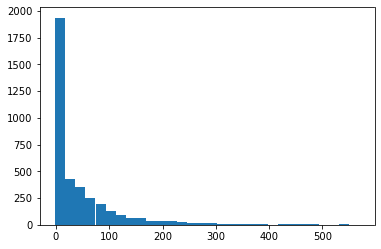

In [671]:

plt.hist(twt_seps, 30)
plt.show()

In [672]:
def group_sep(tweets):
    sep = -1
    for i,gi in enumerate(tweets[1:]):
        if gi.departday is None:
            sep = max(sep, abs((gi.timestamp - tweets[i].timestamp).total_seconds()/60))
    return sep

sep_tweets = sorted([(g,group_sep(g)) for g in grouped], key=lambda x: -x[1])


In [673]:
for s in sep_tweets[:20]:
    print(s[1])
    for g in s[0]:
        print('\t',g.timestamp,': ', g.text)
    print('--')

569.4666666666667
	 2021-02-16 19:11:00+00:00 :  Service Advisory: Auto Train 52 scheduled to depart Sanford (SFA) on 2/18 and Auto Train 53 scheduled to depart Lorton (LOR) on 2/18 are canceled due to equipment and weather-related issues. For reservation assistance, please call 800-USA-RAIL.
	 2021-02-17 04:40:28+00:00 :  Auto Train 52 scheduled to depart Sanford (SFA) on 2/16 currently operating approximately 7hrs 30mins late due to the arrival of late inbound equipment which delayed its departure out of Sanford (SFA).
--
547.15
	 2021-06-15 04:58:58+00:00 :  UPDATE: Southwest Chief Train 3 that departed Chicago (CHI) on 6/13 remains stopped at Albuquerque (ABQ) due to a freight train derailment ahead where it will hold until track reopens. Extensive delays are expected. Updates to follow as new information becomes available.
	 2021-06-15 14:06:07+00:00 :  UPDATE: Southwest Chief Train 3 that departed Chicago (CHI) on 6/13 continues to hold at Albuquerque (ABQ) due to a freight train

In [674]:
delays = set(t[-2] for t in train_infos)
delays

{10,
 100,
 1010,
 1030,
 105,
 110,
 115,
 1155,
 120,
 1200,
 125,
 130,
 135,
 140,
 145,
 1480,
 15,
 150,
 155,
 160,
 165,
 1675,
 170,
 175,
 180,
 185,
 190,
 195,
 20,
 200,
 205,
 210,
 215,
 220,
 225,
 230,
 235,
 240,
 245,
 25,
 250,
 255,
 260,
 265,
 270,
 275,
 280,
 285,
 290,
 295,
 30,
 300,
 305,
 310,
 315,
 320,
 325,
 330,
 335,
 340,
 345,
 35,
 350,
 360,
 365,
 370,
 375,
 380,
 385,
 390,
 395,
 40,
 400,
 405,
 410,
 415,
 420,
 425,
 430,
 435,
 440,
 445,
 45,
 450,
 455,
 46,
 460,
 465,
 470,
 475,
 480,
 485,
 495,
 5,
 50,
 500,
 505,
 510,
 515,
 520,
 525,
 530,
 535,
 540,
 545,
 55,
 550,
 555,
 565,
 570,
 575,
 580,
 585,
 60,
 600,
 615,
 620,
 630,
 640,
 65,
 670,
 680,
 690,
 70,
 705,
 710,
 720,
 75,
 750,
 765,
 770,
 780,
 80,
 810,
 820,
 85,
 870,
 875,
 90,
 910,
 930,
 940,
 95,
 96,
 None}

In [675]:
infoct = 0
noReasonNoTime = []
noReasonYesTime = []
yesReasonNoTime = []
yesReasonYesTime = []
for g in grouped:
    reason = False
    time = False
    for gi in g:
        if gi.reason is not None:
            reason = True
        if gi.delaytime is not None:
            time = True
            
    if reason and time:
        yesReasonYesTime.append(g)
    elif reason and not time:
        yesReasonNoTime.append(g)
    elif time and not reason:
        noReasonYesTime.append(g)
    else:
        noReasonNoTime.append(g)
print(len(grouped))        
print('Yes reason/Yes time: ', len(yesReasonYesTime))
print('Yes reason/No time:  ', len(yesReasonNoTime))
print('No reason/Yes time:  ', len(noReasonYesTime))
print('No reason/No time:   ', len(noReasonNoTime))

6252
Yes reason/Yes time:  4679
Yes reason/No time:   514
No reason/Yes time:   831
No reason/No time:    228


In [676]:
for ts in yesReasonNoTime[:40]:
    for t in ts:
        print(t.timestamp, t.text)
    print('--')

2021-11-23 14:25:39+00:00 Carolinian Train 80 is currently stopped east of Greensboro (GRO) due to a vehicle on the tracks. Updates to come.
--
2021-11-19 01:30:53+00:00 California Zephyr Train 5 which departed Chicago (CHI) on 11/16 is currently experiencing a delay east of Emeryville (EMY) due to a vehicle on the tracks ahead.
--
2021-11-17 23:02:50+00:00 Illini Train 393 is delayed departing Chicago (CHI) due to mechanical issues. Updates to follow.
--
2021-11-17 22:44:48+00:00 Empire Builder Train 8 which departed Seattle (SEA) on 11/16 is currently holding in Red Wing (RDW) due to police activity.
--
2021-11-15 02:49:37+00:00 Cascades Train 508 is currently stopped south of Portland (PDX) due to freight train interference and rail congestion.
--
2021-11-13 18:15:13+00:00 Coast Starlight Train 14 which is due to depart Los Angeles (LAX) on 11/13 is being delayed departing due to mechanical problems. Updates to come.
--
2021-11-12 22:43:02+00:00 Sunset Limited Train 2 which departed

In [677]:
for ts in noReasonYesTime[:40]:
    for t in ts:
        print(t.timestamp, t.text)
    print('--')

2021-11-25 02:05:41+00:00 Valley Flyer Train 494 is currently operating approximately 45mins late into Hartford (HFD).
--
2021-11-25 01:51:18+00:00 Illini Train 393 is currently operating approximately 30mins late into Centralia (CEN).
--
2021-11-25 01:48:23+00:00 Wolverine Train 354 is currently operating approximately 35mins late into Niles (NLS).
--
2021-11-25 01:48:02+00:00 Missouri River Runner Train 316 is currently operating approximately 35mins late into Hermann (HEM).
--
2021-11-24 22:04:36+00:00 Carolinian Train 80 which departed Charlotte (CLT) on 11/24, is currently operating approximately 1hr 20mins late into Alexandria (ALX).
--
2021-11-24 19:02:17+00:00 Lincoln Service Train 303 is currently operating approximately 30 minutes late.
--
2021-11-24 18:12:42+00:00 Missouri River Runner Train 311 is currently operating approximately 30mins late approaching Sedalia (SED).
--
2021-11-24 16:51:34+00:00 Saluki Train 391 is currently operating 30mins late departing Rantoul (RTL).


In [719]:
numreasons = []
nonearlyreasons = []
total_reasons = 0
for d in yesReasonYesTime:
    nr = []
    ner = []
    for t in d:
        if t.reason is not None:
            nr.append(t.reason)
            total_reasons += 1
            if 'earlier' not in t.reason:
                ner.append(t.reason)
    numreasons.append(len(set(nr)))
    nonearlyreasons.append(len(set(ner)))
numreasons = np.array(numreasons)
nonearlyreasons = np.array(nonearlyreasons)
print(sum(numreasons > 1))
print(total_reasons)
print(sum(numreasons < 1))
print()
print(sum(nonearlyreasons > 1))
print(sum(nonearlyreasons < 1))

612
5692
0

341
1245


In [679]:
# Ok, for each tweet group, determine what is causing delays
errors = 0
for group in yesReasonYesTime:
    unresolved_delay = 0
    delay = 0
    for tweet in group:
        if tweet.delaytime is not None:
            unresolved_delay = tweet.delaytime
        if unresolved_delay > 0:
            if unresolved_delay < delay:
                if max(unresolved_delay+10,unresolved_delay*1.2) < delay:
                    print('Delay reduced: ')
                    errors += 1
                    for t in group:
                        print('\t',t.timestamp, t.text)
                    print('--')
#                     raise Error()
            delay = unresolved_delay
            unresolved_delay = 0

print(errors)        

Delay reduced: 
	 2021-09-30 10:21:45+00:00 Southwest Chief Train 4 which departed Los Angeles (LAX) on 9/29 is currently operating approximately 4 hours 30 minutes late due to mechanical problems east of Kansas City (KCY).
	 2021-09-30 22:36:01+00:00 Southwest Chief Train 4, which departed Los Angeles (LAX) on 9/29, is stopped west of Raton (RAT) due to the arrival of a late inbound connection. Updates to follow.
	 2021-09-30 23:11:04+00:00 UPDATE: Southwest Chief Train 4 which departed Los Angeles (LAX) on 9/29 is back on the move and currently operating approximately 55mins late.
--
Delay reduced: 
	 2021-08-22 14:13:31+00:00 Crescent Train 20 which departs New Orleans (NOL) today 8/22 is currently experiencing a delayed departure out of NOL due to a disabled freight train blocking the tracks. We will update as more information becomes available.
	 2021-08-22 15:24:21+00:00 Update: Crescent Train 20 which departs New Orleans (NOL) today 8/22 is now on the move currently operating ap

In [680]:

reasons = set(t.reason for ts in yesReasonYesTime for t in ts)
print(len(reasons))
reasons

2695


{'due to holding for inbound connecting customers',
 'due to earlier engine issues, signal issues and freight train interference along its route',
 'due to earlier mechanical issues and freight train interference along the route',
 'due to freight train interference and engine issues along its route',
 'due to a late turn of inbound equipment in St',
 'due to law enforcement activity',
 'due to earlier freight train interference west of SAS',
 'due to freight train interference, weather-related delays, and signal issues along the route',
 'due to earlier mechanical issues west of Albion (ALI)',
 'due to flash flooding and fallen commercial power lines in the area',
 'due to earlier freight train interference north of Centralia (CTL)',
 'due to earlier equipment and mechanical issues, along with freight train interference in its route',
 'due to a disabled vehicle blocking the tracks south of Jacksonville (JAX)',
 'due to the mechanical issues',
 'due to a medical emergency onboard',
 '

In [681]:
group[0].timestamp

Timestamp('2020-09-04 07:11:54+0000', tz='UTC')

In [682]:
ngg = NgramGlue()
for ts in yesReasonYesTime:
    for t in ts:
        if t.reason is not None:
            ngg.add(t.reason[7:], 6)
ngg.build_tree()
for n in ngg.node_dict.values():
    n.set_dominant()



In [722]:
def clean_gram(g):
    if g[0]=='@BOT@':
        g = g[1:]
    if g[-1] == '@EOT@':
        g = g[:-1]
    return g

dominant_grams = sorted([ (t,n.dominant_thresh, n.count) for t,n in ngg.node_dict.items() if n.dominant], key=lambda x: -x[1])
print(len(dominant_grams))
nonparen = [(clean_gram(t),n,c) for t,n,c in dominant_grams if '(' not in ''.join(t) and n>0]
print(len(nonparen))
nonparen

20627
396


[(('gate', 'crossings'), 1.2578669667841647, 9),
 (('passenger', 'on', 'board'), 1.2337072083098177, 6),
 (('Norfolk', 'Southern'), 1.1710021763238225, 51),
 (('speed', 'restrictions'), 1.1465900343424749, 646),
 (('single', 'tracking'), 1.1440841499245182, 9),
 (('maritime', 'traffic'), 1.1402561312431172, 24),
 (('will', 'be'), 1.0369651965066826, 7),
 (('caused', 'by'), 1.004497023956375, 15),
 (('rail', 'congestion'), 0.9934322263365177, 761),
 (('host', 'railroad'), 0.9653462080367197, 27),
 (('fire', 'department'), 0.9546016309121339, 53),
 (('power', 'lines'), 0.933519991021188, 14),
 (('Salt', 'Lake'), 0.9288329973773979, 9),
 (('holding', 'for'), 0.909139126217603, 60),
 (('track', 'work'), 0.896200577367717, 177),
 (('Texas', 'Eagle'), 0.7531669960389694, 7),
 (('trespasser', 'incident'), 0.6790437569360038, 153),
 (('police', 'activity'), 0.6303363285117055, 122),
 (('downed', 'trees'), 0.5998274067041066, 38),
 (('law', 'enforcement'), 0.5268508340766235, 45),
 (('late', 'a

In [723]:
print('\n'.join('%s' % (' '.join(t)) for i,(t,n,c) in enumerate(nonparen) if n>0))

gate crossings
passenger on board
Norfolk Southern
speed restrictions
single tracking
maritime traffic
will be
caused by
rail congestion
host railroad
fire department
power lines
Salt Lake
holding for
track work
Texas Eagle
trespasser incident
police activity
downed trees
law enforcement
late arrival
which delayed
weather-related delays
due to
departure out
departure from
crew change
is being
along the route
which delayed its departure
Steel Bridge
signal issues
heat related
inbound equipment
#/## is
mechanical issues
in its path
south of
EMS assisting
along its route
downed tree
west of
severe weather
boarding delays
in the area
host railroad's
north of
medical emergency
ongoing weather-related track closure
bridge opening
freight train
earlier
bridge inspection
blocking the tracks
through the area
debris on
a disabled
an earlier mechanical issue
heat-related weather
Texas Eagle Train ###
east of
connecting service
disabled freight train in its path
weather related
with the gate cross

In [730]:
print('\n'.join('%d. %s (%d) (%d)' 
                % (i,' '.join(t), sum( max(' '.join(t) in tw.reason for tw in ts if tw.reason is not None) 
                                      for ts in yesReasonYesTime ), c) for i,(t,n,c) in enumerate([(t,n,c) for t,n,c in nonparen if n>0 and c>10])))

0. Norfolk Southern (47) (51)
1. speed restrictions (634) (646)
2. maritime traffic (24) (24)
3. caused by (14) (15)
4. rail congestion (741) (761)
5. host railroad (32) (27)
6. fire department (43) (53)
7. power lines (10) (14)
8. holding for (58) (60)
9. track work (168) (177)
10. trespasser incident (108) (153)
11. police activity (109) (122)
12. downed trees (33) (38)
13. law enforcement (45) (45)
14. late arrival (120) (124)
15. which delayed (76) (76)
16. weather-related delays (123) (131)
17. due to (4679) (23)
18. departure out (46) (47)
19. departure from (54) (54)
20. crew change (58) (54)
21. along the route (532) (538)
22. which delayed its departure (74) (74)
23. signal issues (543) (561)
24. inbound equipment (142) (151)
25. mechanical issues (627) (699)
26. in its path (88) (101)
27. south of (333) (343)
28. along its route (372) (377)
29. downed tree (51) (21)
30. west of (343) (356)
31. severe weather (37) (37)
32. boarding delays (33) (33)
33. in the area (59) (65)
34

In [686]:
numdelays = []
for infos in yesReasonYesTime:
    nr = []
    for t in infos:
        if t.delaytime is not None:
            nr.append(t.delaytime)
            if t.delaytime == 0:
                print(t.text)
    nr = set(nr)
    numdelays.append(len(nr))
    if len(nr) > 1:
        print(nr, len(infos))
        for t in infos:
            print(t.timestamp, t.day, '\n\t', t.text)
        print('-----')

numdelays = np.array(numdelays)
print( sum(numdelays > 1))
print( sum(numdelays < 1))
print(numdelays[numdelays>1])
    

{145, 95} 2
2021-11-21 01:22:52+00:00 325 
	 Silver Star Train 92 which departed Miami (MIA) on 11/20, is currently operating approximately 1hr 35mins late due to earlier rail congestion and signal issues along its route.
2021-11-21 14:44:45+00:00 325 
	 Silver Star Train 92 which departed from Miami (MIA) on 11/20 is currently operating approximately 2hrs 25mins late due to earlier signal issues, freight train interference, and mechanical issues north of Tampa (TPA).
-----
{35, 340} 4
2021-11-19 19:04:30+00:00 323 
	 Missouri River Runner Train 311 is currently operating approximately 35mins late into Lee’s Summit (LEE).
2021-11-19 20:09:28+00:00 323 
	 Missouri River Runner Train 311 is stopped east of Lee’s Summit (LEE) due to freight train interference. Updates to follow.
2021-11-19 20:58:07+00:00 323 
	 UPDATE: Missouri River Runner Train 311 remains stopped east of Lee’s Summit (LEE). Updates to follow.
2021-11-20 00:51:57+00:00 324 
	 UPDATE: Missouri River Runner Train 311 is b

2021-10-04 16:50:10+00:00 277 
	 Saluki Train 391 is currently operating approximately 30mins late due to rail congestion and freight train interference along the route.
2021-10-04 18:44:37+00:00 277 
	 Saluki Train 391 is currently operating approx. 40min late due to earlier commuter train interference, sped restrictions and freight train interference along the route.
-----
{80, 50} 2
2021-10-04 16:09:58+00:00 277 
	 Lincoln Service Train 303 is currently operating approximately 50mins late due to earlier mechanical issues south of Summit (SMT).
2021-10-04 18:43:05+00:00 277 
	 UPDATE: Lincoln Service Train 303 is currently operating approx. 1hr 20min late due to earlier freight train interference north of Springfield (SPI).
-----
{480, 720} 6
2021-10-04 10:21:28+00:00 277 
	 Auto Train 52 which departed from Sanford (SFA) on 10/3 is currently stopped south of Sanford (SFA) due to mechanical issues. We will update when more information is available.
2021-10-04 11:19:21+00:00 277 
	 CO

2021-08-29 17:27:10+00:00 241 
	 Missouri River Runner Train 311 is currently operating approximately 40min late outside of Sedalia (SED).
2021-08-29 18:02:51+00:00 241 
	 Missouri River Runner Train 311 is currently operating approximately 35mins late due to earlier rail congestion between Jefferson City (JEF) and Sedalia (SED).
-----
{65, 35} 2
2021-08-28 23:41:09+00:00 240 
	 Missouri River Runner Train 316 is currently operating approximately 35mins late due to mechanical issues and freight train interference along the route.
2021-08-29 00:35:18+00:00 241 
	 UPDATE: Missouri River Runner Train 316 is currently operating approximately 1hr 5mins late approaching Jefferson City (JEF).
-----
{25, 45} 3
2021-08-28 02:16:16+00:00 240 
	 Amtrak Cascades Train 508 is currently operating approximately 25mins late due to freight train interference and speed restrictions along its route.
2021-08-28 04:40:31+00:00 240 
	 Amtrak Cascades Train 508 is stopped north of Kelso (KEL) due to mechanic

	 California Zephyr Train 6 which departed from Emeryville (EMY) on 7/29 is currently stopped east of Elko (ELK) due to freight train interference. We will update when more information is available.
2021-07-30 14:46:58+00:00 211 
	 UPDATE: California Zephyr Train 6 which departed from Emeryville (EMY) on 7/29 is back on the move and currently operating approximately 7hrs 55mins late.
-----
{90, 165} 5
2021-07-30 12:23:16+00:00 211 
	 Hiawatha Train 330 is currently stopped at Milwaukee Airport Rail Station (MKA). We will update when more information is available.
2021-07-30 12:55:29+00:00 211 
	 UPDATE: Hiawatha Train 330 is currently stopped at Milwaukee Airport Rail Station (MKA) due to mechanical issues. We will update when more information is available.
2021-07-30 13:09:23+00:00 211 
	 UPDATE: Hiawatha Train 330 is back on the move and currently operating approximately 1hr 30mins late.
2021-07-30 13:48:43+00:00 211 
	 Hiawatha Train 330 is currently stopped east of Sturtevant (SVT)

-----
{200, 390} 4
2021-07-24 23:57:00+00:00 205 
	 Southwest Chief Train 3, which departed Chicago (CHI) on 7/23, is stopped west of Albuquerque (ABQ) due to freight train interference. We will update as more information becomes available.
2021-07-25 01:05:10+00:00 206 
	 UPDATE: Southwest Chief Train 3, which departed from Chicago (CHI) on 7/23 is stopped west of Albuquerque (ABQ) due to freight train interference. We will update when more information is available.
2021-07-25 02:09:52+00:00 206 
	 UPDATE: Southwest Chief Train 3 which departed from Chicago (CHI) on 7/23 is back on the move and currently operating approximately 3hrs 20mins late.
2021-07-25 17:49:56+00:00 206 
	 Southwest Chief Train 3 which departed Chicago (CHI) on 7/23 is on the move and currently operating approx. 6hr 30min late.
-----
{40, 25} 2
2021-07-25 13:55:57+00:00 206 
	 Lincoln Train 301 is currently operating approx. 25min late due to an earlier mechanical issue and freight train interference south of Chi

	 UPDATE: California Zephyr Train 6 which departed Emeryville (EMY) on 6/8 which was stopped west of Omaha (OMA) is back on the move operating approximately 6 hours 20 minutes late.
-----
{250, 415} 3
2021-07-09 12:47:55+00:00 190 
	 California Zephyr Train 5 which departed Chicago (CHI) on 7/7 is currently stopped east of Elko (ELK) due to a disabled freight train blocking the tracks. Updates to come.
2021-07-09 13:22:42+00:00 190 
	 UPDATE: California Zephyr Train 5 which departed Chicago (CHI) on 7/7 which was stopped east of Elko (ELK) is back on the move operating approximately 4 hours 10 minutes late.
2021-07-10 01:20:48+00:00 191 
	 UPDATE: California Zephyr Train 5 which departed from Chicago (CHI) on 7/7 is currently operating approximately 6hrs 55mins late due to earlier weather-related delays, rail congestion, and freight train interference west of Winnemucca (WNN).
-----
{115, 30} 3
2021-07-09 11:06:02+00:00 190 
	 Carolina Train 80 is currently stopped north of Charlotte (

2021-07-03 22:07:52+00:00 184 
	 Blue Water Train 364 is currently operating approx. 55min late due to earlier assisting of a disabled train east of Chicago (CHI).
2021-07-04 01:53:59+00:00 185 
	 Blue Water Train 364 is currently operating approx. 1hr 55min late due to earlier mechanical issues west of East Lansing (LNS).
-----
{90, 60} 4
2021-07-03 14:44:20+00:00 184 
	 Lincoln Train 303 is being delayed south of Chicago (CHI) due to a disabled freight train ahead. We will update as additional information becomes available.
2021-07-03 15:20:32+00:00 184 
	 UPDATE: Lincoln Train 303 is still being delayed south of Chicago (CHI) due to a disabled freight train ahead. We will continue to update as additional information becomes available.
2021-07-03 15:38:19+00:00 184 
	 UPDATE: Lincoln Train 303 is back on the move operating approx. 1hr late.
2021-07-03 17:32:59+00:00 184 
	 UPDATE: Lincoln Train 303 is currently operating approx. 1hr 30min late south of Dwight (DWT) due to earlier fre

2021-06-14 06:55:20+00:00 165 
	 UPDATE: Coast Starlight Train 11 that departed Seattle (SEA) on 6/13 is back on the move and currently operating approx 6 hr 40 min late.
2021-06-14 07:44:41+00:00 165 
	 Coast Starlight Train 11 that departed Seattle (SEA) on 6/13 is currently stopped south of Eugene (EUG) due to ongoing mechanical issues. Updates to follow as more information becomes available.
2021-06-14 08:41:39+00:00 165 
	 UPDATE: Due to ongoing mechanical issues Coast Starlight Train 11 that departed Seattle (SEA) on 6/13 has reversed back to Eugene (EUG) where it is currently stopped. Updates to follow as more information becomes available.
2021-06-14 10:52:41+00:00 165 
	 UPDATE: Due to ongoing mechanical issues Coast Starlight Train 11 that departed Seattle (SEA) on 6/13 is now on the move currently operating approximately 10hr 40min late.
2021-06-14 12:42:09+00:00 165 
	 Coast Starlight Train 11 that departed Seattle (SEA) on 6/13 is currently stopped south of Chemult (CMO) d

	 UPDATE: Coast Starlight Train 14 that departed Los Angeles (LAX) on 6/8 is on the move currently operating approx. 4hr late.
-----
{210, 215} 5
2021-06-09 11:32:17+00:00 160 
	 Coast Starlight Train 11 that departed Seattle (SEA) on 6/8 is currently stopped south of Redding (RDD) due to a disabled freight train ahead. We will update as additional information becomes available.
2021-06-09 12:08:44+00:00 160 
	 UPDATE: Coast Starlight Train 11 that departed Seattle (SEA) on 6/8 is still stopped south of Redding (RDD) due to a disabled freight train ahead. We will continue to update as additional information becomes available.
2021-06-09 13:10:40+00:00 160 
	 UPDATE: Coast Starlight Train 11 that departed Seattle (SEA) on 6/8 continues to be delayed south of Redding (RDD) due to a disabled freight train ahead. We will update as additional information becomes available.
2021-06-09 13:36:29+00:00 160 
	 UPDATE: Coast Starlight Train 11 that departed Seattle (SEA) on 6/8 is back on the mov

	 UPDATE: Auto Train 53 that departed Lorton (LOR) on 5/5 which was stopped in Yamassee is back on the move operating approximately 16 hours 50 minutes late.
2021-05-07 08:01:54+00:00 127 
	 Auto Train 53 scheduled to depart Lorton (LOR) on 5/6 has now departed Lorton (LOR) and is currently operating approximately 11hrs 45mins late.
-----
{60, 30} 2
2021-05-06 12:33:30+00:00 126 
	 Wolverine Train 351 is currently operating approx. 30min late due to earlier debris on the tracks west of Ann Arbor (ARB)
2021-05-06 15:39:32+00:00 126 
	 Update: Wolverine Train 351 is now operating approximately 1hr late outside of Chicago (CHI).
-----
{35, 95} 3
2021-05-06 02:23:55+00:00 126 
	 Pere Marquette Train 370 is currently operating approx 35 min late.
2021-05-06 02:55:28+00:00 126 
	 Pere Marquette Train 370 is currently stopped at Bangor (BAM) due to mechanical issues. Updates to follow as more information becomes available.
2021-05-06 03:28:33+00:00 126 
	 UPDATE: Pere Marquette Train 370 is b

{40, 135} 5
2021-04-18 00:10:36+00:00 108 
	 Amtrak Cascades Train 505 is currently stopped at Kelso-Longview (KEL) due to mechanical issues. We will update when more information is available.
2021-04-18 00:36:19+00:00 108 
	 UPDATE: Amtrak Cascades Train 505 is back on the move and currently operating approximately 40mins late.
2021-04-18 01:54:05+00:00 108 
	 Amtrak Cascades Train 505 is currently stopped at Portland (PDX) due to Portland Steel Bridge issues. We will update when more information is available.
2021-04-18 02:49:00+00:00 108 
	 UPDATE: Amtrak Cascades Train 505 remains stopped at Portland (PDX). Updates to follow.
2021-04-18 03:22:45+00:00 108 
	 UPDATE: Amtrak Cascades Train 505 is back on the move and currently operating approximately 2hrs 15mins late.
-----
{50, 95} 2
2021-04-17 14:26:43+00:00 107 
	 Pennsylvanian Train 42 is currently operating approx. 50min late due to earlier freight train interference east of Latrobe (LAB).
2021-04-17 16:16:17+00:00 107 
	 UPDATE

{140, 205, 55} 5
2021-02-17 02:53:29+00:00 48 
	 Lincoln Service Train 306 is currently operating approximately 55 minutes late due to the late arrival of inbound equipment and switch problems north of St. Louis (STL).
2021-02-17 03:21:20+00:00 48 
	 Lincoln Service Train 306 is currently stopped south of Springfield (SPI) due to weather-related switch issues. Updates to follow as more information becomes available.
2021-02-17 04:03:20+00:00 48 
	 UPDATE: Lincoln Service Train 306 is back on the move and currently operating approx 2 hr 20 min late.
2021-02-17 07:00:43+00:00 48 
	 UPDATE: Lincoln Service Train 306 is currently stopped north of Dwight (DWT). Updates to follow as more information becomes available.
2021-02-17 07:09:19+00:00 48 
	 UPDATE: Lincoln Service Train 306 is back on the move and currently operating approx 3 hr 25 min late.
-----
{155, 110} 3
2021-02-16 19:17:41+00:00 47 
	 Wolverine Train 352 will be delayed departing Chicago (CHI) due to the late arrival of inbou

2021-02-13 12:05:41+00:00 44 
	 Update: Texas Eagle Train 22 which departed San Antonio (SAS) on 2/12 is back on the move currently operating approx. 4hr 15min late. Additional delay is expected due to a freight train interference ahead.
2021-02-13 14:26:13+00:00 44 
	 SERVICE ALERT: Due to a freight train derailment north of Springfield (SPI), Train 22 which departed San Antonio (SAS) on 2/12 will detour between St. Louis (STL) and Chicago (CHI) missing all intermediate stops. Alternate transportation will be provided between STL and CHI.
2021-02-13 23:09:35+00:00 44 
	 Texas Eagle Train 22/422 which departed San Antonio (SAS)/Los Angeles (LAX) on 2/12 / 2/10 is currently operating approximately 8 hours late.
-----
{150, 95} 3
2021-02-11 22:12:29+00:00 42 
	 Blue Water Train 364 is being delayed departing Chicago (CHI) due to mechanical problems.
2021-02-11 23:40:53+00:00 42 
	 UPDATE: Train 364 has departed and is operating approximately 1 hour 35 minutes late.
2021-02-12 03:12:22+00

2020-12-02 15:20:03+00:00 337 
	 Update: Illinois Zephyr Train 380 is currently operating approximately 40min late departing Princeton (PCT) due to mechanical issues.
-----
{235, 245} 6
2020-11-29 05:01:25+00:00 334 
	 Sunset Limited Train 1/Texas Eagle Train 421 which departed New Orleans (NOL)/Chicago (CHI) on 11/28/11/27 is currently stopped east of San Antonio (SAS) due to a disabled freight train. Updates to follow as more information becomes available.
2020-11-29 06:05:27+00:00 334 
	 UPDATE: Sunset Limited Train 1/Texas Eagle Train 421 which departed New Orleans (NOL)/Chicago (CHI) on 11/28/11/27 remains stopped east of San Antonio (SAS). Updates to follow as more information becomes available.
2020-11-29 07:06:45+00:00 334 
	 UPDATE: Sunset Limited Train 1/Texas Eagle Train 421 which departed New Orleans (NOL)/Chicago (CHI) on 11/28/11/27 is still stopped east of San Antonio (SAS). Updates to follow.
2020-11-29 07:17:38+00:00 334 
	 UPDATE: Sunset Limited Train 1/Texas Eagle Tr

2020-11-12 16:38:21+00:00 317 
	 Palmetto Train 89 is currently operating approx. 1hr 10min late due to earlier signal issues and rail congestion south of New Carrollton (NCR).
2020-11-12 18:51:22+00:00 317 
	 UPDATE: Palmetto Train 89 is currently operating approx. 1hr 45min late due to signal issues and weather-related delays between New Carrollton (NCR) and Richmond (RVR).
-----
{50, 90, 130} 3
2020-11-12 13:48:28+00:00 317 
	 Carolinian Train 80 is currently operating approx. 50min late due to flash flood warnings south of Greensboro (GRO).
2020-11-12 16:04:54+00:00 317 
	 UPDATE: Carolinian Train 80 is currently operating approx. 1hr 30min late north of Durham (DNC) due to flash flood warnings along the route.
2020-11-12 18:43:07+00:00 317 
	 UPDATE: Carolinian Train 80 is currently operating approx. 2hr 10min late due to flash flood warnings along the route south of Selma-Smithfield (SSM).
-----
{345, 405} 4
2020-11-11 23:06:25+00:00 316 
	 Auto Train 52 which departed Sanford (S

{120, 75} 3
2020-09-22 17:37:28+00:00 266 
	 California Zephyr Train 1105 that departed Chicago (CHI) on 9/21 is being delayed west of Denver (DEN) due to a mechanical issue. The crew is working to resolve the issue. We will update as more information becomes available.
2020-09-22 18:13:00+00:00 266 
	 Update: California Zephyr Train 1105 that departed Chicago (CHI) on 9/21 is back on the move currently operating approx. 1hr 15min late.
2020-09-22 21:29:02+00:00 266 
	 UPDATE: California Zephyr Train 1105 that departed Chicago (CHI) on 9/21 is currently operating approx. 2hr late.
-----
{280, 315} 5
2020-09-21 23:21:21+00:00 265 
	 Cascades Train 505 is currently stopped in Tacoma (TAC) due to mechanical issues. We will provide updates as more information becomes available.
2020-09-22 00:24:38+00:00 266 
	 UPDATE: Cascades Train 505 is currently stopped in Tacoma (TAC) due to mechanical issues. We will update when more information is available.
2020-09-22 01:42:34+00:00 266 
	 UPDATE: 

[2 2 2 2 2 2 3 2 3 2 2 3 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 4 2 2 2 4 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 3 2 2 2 4 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 2 2 2 4 2 2 2 2 2 5 2 2 2 3 3 2 2 4 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 3 2 3 2 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2
 2 3 2 2 2 2 2 3 3 3 2 2 2 4 2 2 2 3 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3
 2 2 2 2 2 2 2 3 3 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 2 2 2 3 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 2 2 2 2
 2 2 3 2 2 2 2 3 2 2 2 2 

## Check that we found all the reasons

In [687]:
# Identified reasons
REASONS = """boarding delays
bridge repairs
commuter train interference
debris on the tracks
delayed arrival of inbound equipment
disabled commuter train
disabled Norfold Southern freight train
disabled UP freight
disabled train
tree
powerlines
EMS
equipment change
fallen power lines
fallen tree
fire department
holding for connecting trains
late inbound train equipment
law enforcement personnel
maritime traffic
mechanical issue
medical emergency personnel activity
rail traffic
routing delays
routing delays
scheduled crew changes
severe weather
switch problem
trackwork
tree on the tracks
vehicle crossing incident
vehicle on the tracks
bridge inspection
freight train interference
late arrival of inbound equipment
vehicle incident
track work
rail congestion
speed restriction
police activity
weather-related
trespasser incident
mechanical issue
signal issue
mechanical problem
engine issues
signal problem
disabled freight
equipment issue
freight interference""".split('\n') + """assisting a passenger on board
single tracking
problems with the gate crossings
freight train congestion
power line
dispatching issue on the host railroad
holding for a late inbound connection
crew change
flash flood warning
holding for connecting passengers
late inbound equipment
track closure
track inspection
switch issue
dispatching issue
heat-related weather issue
switch issue
bridge issue
late inbound connection
freight derailment ahead
freight train congestion""".split('\n') + """freight train derailment
servicing issue
stopped freight train
boulder on the track
police personnel
Tropical Depression
law enforcement activity
Hurricane
wildfire
flooding
delayed inbound equipment
Tropical Storm
inclement weather
freight derailment
medical emergency
crew issue
broken rail
medical personnel activity
weather
vehicle blocking the track""".split('\n')

In [688]:
# does each tweet reference at least one of these?
uncovered = []
uncovered_groups = []
allreasons = 0
for ts in yesReasonYesTime:
    hasreason_group=False
    for t in ts:
        hasreason = False
        if t.reason is not None:
            allreasons +=1
            for re in REASONS:
                if re in t.reason:
                    hasreason=True
                    hasreason_group = True
                    break
            else:
                uncovered.append(t)
                
    if not hasreason_group:
        uncovered_groups.append(ts)
print(len(uncovered), '/', allreasons)
            


174 / 5692


In [689]:
rzns = []
for t in uncovered:
    if t.reason is not None:
        print(t.reason)
        rzns.append(t.reason)
print(len(set(rzns)))
#     print('--')

due to bridge traffic
due to holding for late inbound connecting customers
due to the late turn of inbound equipment in Chicago (CHI)
due to a disabled work train in the area
due to a previously disabled Norfolk Southern freight train north of Anniston (ATN)
due to depart Miami on 10/26 will be delayed departing
due to West Lake Swing Bridge repairs
due to assisting disabled Train 301 at Joliet (JOL)
due to refueling
due to earlier freight train inference east of Jefferson City (JEF)
due to the late into Michigan City (MCI)
due to earlier Willamette River Drawbridge opening between Portland (PDX) and Vancouver (VAN)
due to earlier late connecting train at San Antonio (SAS)
due to a vehicle on the track
due to disabled Train 7 ahead in the path of the train
due to earlier issues between Martinez (MTZ) and Davis (DAV) and Dunsmuir (DUN) and Klamath Falls (KFS)
due to depart Boston (BOS) on 9/1 is on the move and currently operating approx
due to a freight train incident outside of Dunsmu

In [690]:
import re
def redact_reasons(st, reasons):
    for r in reasons:
        if r in st:
            st = re.sub(r, '@RZN@', st)
#     return st
    st = re.sub('[^ ]+@RZN@','@RZN@',st)
    st = re.sub('@RZN@[^ ]+','@RZN@',st)
    return st.split('@RZN@')


ngg2 = NgramGlue()
for ts in yesReasonYesTime:
    for t in ts:
        if t.reason is not None:
            for r in redact_reasons(t.reason[7:], REASONS):
                ngg2.add(r, 6)
ngg2.build_tree()
for n in ngg2.node_dict.values():
    n.set_dominant()

dominant_grams2 = sorted([ (t,n.dominant_thresh) for t,n in ngg2.node_dict.items() if n.dominant], key=lambda x: -x[1])
print(len(dominant_grams2))
nonparen2 = [(clean_gram(t),n) for t,n in dominant_grams2 if '(' not in ''.join(t) and n>0]
print(len(nonparen2))
nonparen2


12039
147


[(('Norfolk', 'Southern'), 1.7764588727480708),
 (('caused', 'by'), 1.494476022089853),
 (('will', 'be'), 1.4567143960923978),
 (('holding', 'for'), 1.4548827785470813),
 (('along', 'the', 'route'), 1.3788715293509475),
 (('host', 'railroad'), 1.3297324000994655),
 (('will', 'be', 'delayed', 'departing', 'due', 'to'), 1.3113264813949328),
 (('Salt', 'Lake'), 1.2826934601290685),
 (('inbound', 'connecting', 'Texas', 'Eagle', 'Train', '###'),
  1.2499645262721426),
 (('is', 'being', 'delayed', 'departing', 'due', 'to'), 1.1993036997532123),
 (('which', 'delayed', 'its', 'departure'), 1.1789430408650876),
 (('Texas', 'Eagle', 'Train', '###'), 1.1720926575642354),
 (('blocking', 'the', 'tracks'), 1.073313265557726),
 (('along', 'its', 'route'), 0.8996388354922796),
 (('bridge', 'opening'), 0.8718840903066448),
 (('as', 'well', 'as'), 0.760730966906482),
 (('which', 'delayed'), 0.7101447944873314),
 (('departure', 'out'), 0.6763645208918326),
 (('Texas', 'Eagle'), 0.6550512859104791),
 (('d

In [691]:
print('\n'.join('%d. %s (%d)' 
                % (i,' '.join(t), sum( max(' '.join(t) in tw.reason for tw in ts if tw.reason is not None) 
                                      for ts in yesReasonYesTime )) for i,(t,n) in enumerate(nonparen2) if n>0 and len(t)>1))

0. Norfolk Southern (47)
1. caused by (14)
2. will be (7)
3. holding for (58)
4. along the route (532)
5. host railroad (32)
6. will be delayed departing due to (6)
7. Salt Lake (8)
8. inbound connecting Texas Eagle Train ### (0)
9. is being delayed departing due to (7)
10. which delayed its departure (74)
11. Texas Eagle Train ### (0)
12. blocking the tracks (135)
13. along its route (372)
14. bridge opening (12)
15. as well as (6)
16. which delayed (76)
17. departure out (46)
18. Texas Eagle (5)
19. departure from (54)
20. is being (7)
21. heat related (10)
22. delayed its departure out of Sanford (6)
23. in the area (59)
24. Steel Bridge (7)
25. late arrival of inbound (118)
26. near the tracks (45)
27. through the area (12)
28. in its path (88)
29. on the host railroad (16)
30. due to (4679)
31. host railroad's (6)
32. south of (333)
33. equipment problems (7)
34. in the path of the train (13)
35. west of (343)
36. north of (273)
37. connecting service (7)
38. #/## is (0)
40. late 

In [692]:
print('\n'.join('%s' % (' '.join(t)) for i,(t,n) in enumerate(nonparen2) if n>0 and len(t) > 1))

Norfolk Southern
caused by
will be
holding for
along the route
host railroad
will be delayed departing due to
Salt Lake
inbound connecting Texas Eagle Train ###
is being delayed departing due to
which delayed its departure
Texas Eagle Train ###
blocking the tracks
along its route
bridge opening
as well as
which delayed
departure out
Texas Eagle
departure from
is being
heat related
delayed its departure out of Sanford
in the area
Steel Bridge
late arrival of inbound
near the tracks
through the area
in its path
on the host railroad
due to
host railroad's
south of
equipment problems
in the path of the train
west of
north of
connecting service
#/## is
late turn
servicing equipment
train ahead
related issues
east of
late arrival
on the track
an earlier
Michigan City
personnel activity
an unforeseen
ahead in the path of the
path of the train
late connecting
personnel near
late turn of inbound equipment
ahead in the path
along its route
activity near
train blocking the route ahead
debris bloc

## Finally found everything

In [693]:
print('\n'.join(REASONS))

boarding delays
bridge repairs
commuter train interference
debris on the tracks
delayed arrival of inbound equipment
disabled commuter train
disabled Norfold Southern freight train
disabled UP freight
disabled train
tree
powerlines
EMS
equipment change
fallen power lines
fallen tree
fire department
holding for connecting trains
late inbound train equipment
law enforcement personnel
maritime traffic
mechanical issue
medical emergency personnel activity
rail traffic
routing delays
routing delays
scheduled crew changes
severe weather
switch problem
trackwork
tree on the tracks
vehicle crossing incident
vehicle on the tracks
bridge inspection
freight train interference
late arrival of inbound equipment
vehicle incident
track work
rail congestion
speed restriction
police activity
weather-related
trespasser incident
mechanical issue
signal issue
mechanical problem
engine issues
signal problem
disabled freight
equipment issue
freight interference
assisting a passenger on board
single tracking

In [694]:
reason_key = {k:v for k,v in  [ l.split('\t') for l in """assisting a passenger on board	assisting a passenger on board
boarding delays	boarding delays
boulder on the track	boulder on the track
bridge inspection	bridge inspection
bridge issue	bridge issue
bridge repairs	bridge repairs
broken rail	broken rail
commuter train interference	commuter train interference
crew change	crew change
crew issue	crew issue
debris on the tracks	debris on the tracks
delayed arrival of inbound equipment	delayed arrival of inbound equipment
disabled commuter train	disabled commuter train
disabled Norfold Southern freight train	DISABLED FREIGHT
disabled UP freight	DISABLED FREIGHT
disabled freight	DISABLED FREIGHT
disabled train	disabled train
dispatching issue	dispatching issue
EMS	EMS
medical emergency personnel activity	EMS
medical emergency	EMS
medical personnel activity	EMS
engine issues	ENGINE
equipment issue	EQUIPMENT
equipment change	equipment change
fire department	fire department
flash flood warning	flash flood warning
flooding	flooding
freight derailment ahead	FREIGHT DERAILMENT
freight train derailment	FREIGHT DERAILMENT
freight derailment	FREIGHT DERAILMENT
freight train interference	FREIGHT INTERFERENCE
freight interference	FREIGHT INTERFERENCE
freight train congestion	freight train congestion
holding for connecting trains	HOLDING
holding for a late inbound connection	HOLDING
holding for connecting passengers	HOLDING
late inbound train equipment	LATE EQUIP
late arrival of inbound equipment	LATE EQUIP
late inbound equipment	LATE EQUIP
delayed inbound equipment	LATE EQUIP
late inbound connection	late inbound connection
maritime traffic	maritime traffic
mechanical issue	MECHANICAL
mechanical problem	MECHANICAL
law enforcement personnel	POLICE
police activity	POLICE
police personnel	POLICE
law enforcement activity	POLICE
powerlines	POWERLINE
power line	POWERLINE
problems with the gate crossings	problems with the gate crossings
rail congestion	rail congestion
rail traffic	rail traffic
routing delays	routing delays
servicing issue	SERVICING
signal issue	SIGNAL
signal problem	SIGNAL
single tracking	single tracking
speed restriction	speed restriction
stopped freight train	stopped freight train
switch problem	SWITCH
switch issue	SWITCH
track closure	track closure
track inspection	track inspection
trackwork	TRACKWORK
track work	TRACKWORK
tree	TREE
trespasser incident	trespasser incident
vehicle crossing incident	VEHICLE
vehicle on the tracks	VEHICLE
vehicle incident	VEHICLE
vehicle blocking the track	VEHICLE
Tropical Depression	WEATHER
Hurricane	WEATHER
wildfire	WEATHER
Tropical Storm	WEATHER
weather	WEATHER""".split('\n')]}

print(len(reason_key))
print(len(set(reason_key.values())))

78
50


In [695]:
# Ok, for each tweet group, determine what is causing delays
delay_events = []
for group in yesReasonYesTime:
    unresolved_reasons = []
    unresolved_delay = 0
    delay = 0
    for tweet in group:
        if tweet.delaytime is not None:
            unresolved_delay = tweet.delaytime
        if tweet.reason is not None:
            added = False
            for rzn, code in reason_key.items():
                if rzn in tweet.reason:
                    unresolved_reasons.append(code)
                    added = True
            if not added:
                unresolved_reasons.append('OTHER')
        if unresolved_delay > 0 and len(unresolved_reasons) > 0:
            if unresolved_delay < delay:
                if max(unresolved_delay*1.1, unresolved_delay +10) < delay:
                    print('Delay reduced: ')
                    for t in group:
                        print('\t',t.timestamp, t.text)
                    print('--')
            else:
                delay_events.append((tweet, unresolved_delay - delay, set(unresolved_reasons)))
            delay = unresolved_delay
            unresolved_delay = 0
            unresolved_reasons = []
print('===')
for group in noReasonYesTime:
    unresolved_delay = 0
    delay = 0
    for tweet in group:
        if tweet.delaytime is not None:
            unresolved_delay = tweet.delaytime
        if unresolved_delay > 0:
            if unresolved_delay < delay:
                if max(unresolved_delay*1.1, unresolved_delay +10) < delay:
                    print('Delay reduced: ')
                    for t in group:
                        print('\t',t.timestamp, t.text)
                    print('--')
            else:
                delay_events.append((tweet, unresolved_delay - delay, ['NO REASON GIVEN']))
            delay = unresolved_delay
            unresolved_delay = 0
    

Delay reduced: 
	 2021-10-19 16:26:26+00:00 Texas Eagle Train 22 which departed San Antonio (SAS) on 10/19 is being delayed north of Auston (AUS) due to freight train interference.
	 2021-10-19 17:18:21+00:00 UPDATE: Texas Eagle Train 22 which departed San Antonio (SAS) on 10/19 is back on the move operating approximately 1 hour 45 minutes late.
	 2021-10-20 14:21:29+00:00 Texas Eagle Train 22 which departed San Antonio (SAS) on 10/19 is currently stopped south of St. Louis (STL) due to a vehicle on the tracks. Updates to come.
	 2021-10-20 14:56:15+00:00 UPDATE: Train 22 which departed San Antonio (SAS) on 10/19 which was stopped south of St. Louis (STL) is back on the move operating approximately 1 hour 30 minutes late.
--
Delay reduced: 
	 2021-09-30 10:21:45+00:00 Southwest Chief Train 4 which departed Los Angeles (LAX) on 9/29 is currently operating approximately 4 hours 30 minutes late due to mechanical problems east of Kansas City (KCY).
	 2021-09-30 22:36:01+00:00 Southwest Chi

Delay reduced: 
	 2021-06-15 02:19:18+00:00 Southwest Chief Train 4 that departed Los Angeles (LAX) on 6/13 is currently operating approx 3 hr 50 min late due to switch issues, freight interference, and speed restrictions along the route.
	 2021-06-15 03:25:51+00:00 UPDATE: Southwest Chief Train 4 scheduled to depart from Los Angeles (LAX) on 6/14 is still holding in Los Angeles (LAX) due to a freight derailment ahead. Updates to follow as more information becomes available.
	 2021-06-15 03:42:52+00:00 UPDATE: Southwest Chief Train 4 departing from Los Angeles (LAX) on 6/14 is advancing to Gallup (GLP) where it will hold for track opening. Currently operating approx 2 hr 30 min late. Additional delays are to be expected.
	 2021-06-15 10:27:25+00:00 UPDATE: Southwest Chief Train 4 departing from Los Angeles (LAX) on 6/14 is currently operating approximately 5hr late east of Victorville (VRV) due to freight train congestion.
--
Delay reduced: 
	 2021-06-10 02:11:16+00:00 Silver Star Trai

In [696]:
len(delay_events)

6030

In [697]:
delay_events

[(<__main__.Tweet at 0x1cc7030d8e0>, 75, {'fire department'}),
 (<__main__.Tweet at 0x1cc6d4d2400>, 120, {'MECHANICAL', 'rail congestion'}),
 (<__main__.Tweet at 0x1cc75e1f760>, 90, {'rail congestion'}),
 (<__main__.Tweet at 0x1cc702c1c10>, 75, {'trespasser incident'}),
 (<__main__.Tweet at 0x1cc76ecb040>, 120, {'fire department'}),
 (<__main__.Tweet at 0x1cc76ecb460>, 60, {'LATE EQUIP'}),
 (<__main__.Tweet at 0x1cc76ecb100>, 25, {'rail congestion'}),
 (<__main__.Tweet at 0x1cc76ecb250>, 80, {'FREIGHT INTERFERENCE'}),
 (<__main__.Tweet at 0x1cc76ecb3d0>, 50, {'OTHER'}),
 (<__main__.Tweet at 0x1cc76ecb1f0>, 120, {'FREIGHT INTERFERENCE', 'SIGNAL'}),
 (<__main__.Tweet at 0x1cc76ecb400>, 120, {'FREIGHT INTERFERENCE'}),
 (<__main__.Tweet at 0x1cc76ecb370>, 35, {'SIGNAL', 'rail congestion'}),
 (<__main__.Tweet at 0x1cc76ecb310>,
  35,
  {'rail congestion', 'speed restriction'}),
 (<__main__.Tweet at 0x1cc76ecba60>, 120, {'MECHANICAL'}),
 (<__main__.Tweet at 0x1cc76ecb430>, 30, {'rail congest

## Analyze distribution of causes

In [698]:
tmin = tweets_df10k['Datetime'].min()
tmax = tweets_df10k['Datetime'].max()
print('Date range:', tmin, tmax)
print((tmax-tmin).days)

Date range: 2020-09-04 07:11:54+00:00 2021-11-25 02:50:15+00:00
446


In [699]:
CODES = set(list(reason_key.values()) + ['OTHER'] + ['NO REASON GIVEN'])
number_events = {k: 0 for k in CODES}
duration_events = {k: 0 for k in CODES}
uniq_number_events = {k: 0 for k in CODES}
uniq_duration_events = {k: 0 for k in CODES}
delay_reasons = 0
freight = 0
freight_time = 0
sole_freight = 0
sole_freight_time = 0
for tweet, delay, codes in delay_events:
    f_check = False
    sf_check = True
    for code in codes:
        number_events[code] += 1
        duration_events[code] += delay
        if len(codes) == 1:
            uniq_number_events[code] += 1
            uniq_duration_events[code] += delay
        if 'freight' in code.lower() and not f_check:
            freight += 1
            freight_time += delay
        if 'freight' not in code.lower():
            sf_check = False
    if 'NO REASON GIVEN' not in codes:
        delay_reasons +=1
    if sf_check:
        sole_freight += 1
        sole_freight_time += delay

In [700]:
def delay_cause(rzns):
    delay_reasons = 0
    freight = 0
    freight_time = 0
    sole_freight = 0
    sole_freight_time = 0
    for tweet, delay, codes in delay_events:
        f_check = False
        sf_check = True
        for code in codes:
            if code in rzns and not f_check:
                freight += 1
                freight_time += delay
            if code not in rzns:
                sf_check = False
        if 'NO REASON GIVEN' not in codes:
            delay_reasons +=1
        if sf_check:
            sole_freight += 1
            sole_freight_time += delay    
    return freight, sole_freight, freight_time, sole_freight_time

In [701]:
print('Freight events: ', freight , '/', delay_reasons, ' (%.3f%%)' % (100*freight / delay_reasons))
print('Freight delay: ', freight_time /60)
print('Freight avg delay: ', freight_time / freight)
print()
print('Sole Freight events: ', sole_freight , '/', delay_reasons, ' (%.3f%%)' % (100*sole_freight / delay_reasons))
print('Sole Freight avg delay: ', sole_freight_time / sole_freight)
print('Sole Freight delay: ', sole_freight_time / 60)


Freight events:  2206 / 5179  (42.595%)
Freight delay:  3920.0833333333335
Freight avg delay:  106.62058023572077

Sole Freight events:  1382 / 5179  (26.685%)
Sole Freight avg delay:  105.33646888567294
Sole Freight delay:  2426.25


In [702]:
rcount, sole_rcount, rtime, sole_rtime = delay_cause(['MECHANICAL', 'SIGNAL', 'TRACKWORK', 'ENGINE', 'EQUIPMENT', 'SWITCH'])
print('These reasons events: ', rcount , '/', delay_reasons, ' (%.3f%%)' % (100*rcount / delay_reasons))
print('These reasons delay: ', rtime /60)
print('These reasons avg delay: ', rtime / rcount)
print()
print('Solely these reasons events: ', sole_rcount , '/', delay_reasons, ' (%.3f%%)' % (100*sole_rcount / delay_reasons))
print('Solely these reasons delay: ', sole_rtime / 60)
print('Solely these reasons avg delay: ', sole_rtime / sole_rcount)



These reasons events:  1914 / 5179  (36.957%)
These reasons delay:  2871.6833333333334
These reasons avg delay:  90.021421107628

Solely these reasons events:  1018 / 5179  (19.656%)
Solely these reasons delay:  1400.9333333333334
Solely these reasons avg delay:  82.56974459724951


In [705]:
ratio_events = [ (k,v/len(delay_events)) for k,v in number_events.items()]
ratio_reasons = [ (k,v/delay_reasons) for k,v in number_events.items() if k != 'NO REASON GIVEN']
duration_events_hr = [ (k,v/60) for k,v in duration_events.items()]
uniq_ratio_events = [ (k,v/len(delay_events)) for k,v in uniq_number_events.items()]
uniq_duration_events_hr = [ (k,v/60) for k,v in uniq_duration_events.items()]
avg_delay = [ (k,v/number_events[k]) for k,v in duration_events_hr if number_events[k] > 0]
avg_delay_uniq = [ (k,v/uniq_number_events[k]) for k,v in uniq_duration_events_hr if uniq_number_events[k] > 0]
median_delay = [(k, np.median([d[1] for d in delay_events if k in d[2]])/60) for k in CODES if number_events[k] > 0]
uniq_median_delay = [(k, np.median([d[1] for d in delay_events if k in d[2] and len(d[2]) == 1])/60) for k in CODES if number_events[k] > 0]

In [706]:
sorted(duration_events_hr, key=lambda x: -x[1])

[('FREIGHT INTERFERENCE', 2550.9166666666665),
 ('MECHANICAL', 1563.2666666666667),
 ('DISABLED FREIGHT', 1038.9166666666667),
 ('rail congestion', 995.0),
 ('NO REASON GIVEN', 950.0),
 ('speed restriction', 905.0),
 ('SIGNAL', 796.25),
 ('WEATHER', 536.75),
 ('VEHICLE', 370.4166666666667),
 ('LATE EQUIP', 318.9166666666667),
 ('OTHER', 306.8333333333333),
 ('POLICE', 296.1666666666667),
 ('trespasser incident', 283.25),
 ('TRACKWORK', 259.3333333333333),
 ('freight train congestion', 253.58333333333334),
 ('crew change', 179.33333333333334),
 ('TREE', 138.41666666666666),
 ('fire department', 100.33333333333333),
 ('ENGINE', 98.0),
 ('EQUIPMENT', 88.91666666666667),
 ('FREIGHT DERAILMENT', 69.75),
 ('SWITCH', 65.91666666666667),
 ('bridge inspection', 46.583333333333336),
 ('EMS', 46.25),
 ('debris on the tracks', 43.5),
 ('HOLDING', 36.333333333333336),
 ('flooding', 31.583333333333332),
 ('late inbound connection', 30.416666666666668),
 ('boarding delays', 29.833333333333332),
 ('eq

In [707]:
sorted(uniq_duration_events_hr, key=lambda x: -x[1])

[('FREIGHT INTERFERENCE', 1202.3333333333333),
 ('MECHANICAL', 953.1),
 ('NO REASON GIVEN', 950.0),
 ('DISABLED FREIGHT', 890.8333333333334),
 ('VEHICLE', 288.1666666666667),
 ('rail congestion', 272.9166666666667),
 ('OTHER', 260.5),
 ('trespasser incident', 250.91666666666666),
 ('freight train congestion', 236.33333333333334),
 ('LATE EQUIP', 210.0),
 ('SIGNAL', 177.58333333333334),
 ('POLICE', 154.16666666666666),
 ('WEATHER', 125.66666666666667),
 ('TRACKWORK', 119.08333333333333),
 ('TREE', 117.5),
 ('crew change', 107.25),
 ('speed restriction', 62.416666666666664),
 ('fire department', 59.5),
 ('EQUIPMENT', 57.083333333333336),
 ('SWITCH', 37.416666666666664),
 ('bridge inspection', 37.0),
 ('ENGINE', 34.416666666666664),
 ('FREIGHT DERAILMENT', 33.833333333333336),
 ('disabled train', 27.583333333333332),
 ('flooding', 27.166666666666668),
 ('EMS', 25.416666666666668),
 ('debris on the tracks', 22.833333333333332),
 ('POWERLINE', 22.25),
 ('crew issue', 17.25),
 ('dispatching 

In [708]:
sorted(ratio_events, key=lambda x: -x[1])

[('FREIGHT INTERFERENCE', 0.2751243781094527),
 ('MECHANICAL', 0.15870646766169155),
 ('NO REASON GIVEN', 0.14112769485903814),
 ('rail congestion', 0.12354892205638475),
 ('speed restriction', 0.10630182421227197),
 ('SIGNAL', 0.10132669983416252),
 ('DISABLED FREIGHT', 0.06451077943615258),
 ('WEATHER', 0.0494195688225539),
 ('TRACKWORK', 0.02868988391376451),
 ('VEHICLE', 0.027860696517412936),
 ('OTHER', 0.027197346600331674),
 ('POLICE', 0.027197346600331674),
 ('LATE EQUIP', 0.024875621890547265),
 ('freight train congestion', 0.02321724709784411),
 ('trespasser incident', 0.018739635157545606),
 ('TREE', 0.011276948590381426),
 ('ENGINE', 0.010945273631840797),
 ('EQUIPMENT', 0.009950248756218905),
 ('crew change', 0.009950248756218905),
 ('SWITCH', 0.007794361525704809),
 ('fire department', 0.007296849087893864),
 ('bridge inspection', 0.005804311774461028),
 ('boarding delays', 0.005472636815920398),
 ('debris on the tracks', 0.005306799336650083),
 ('EMS', 0.0046434494195688

In [709]:
for k,r in sorted(ratio_reasons, key=lambda x: -x[1]):
    print(k, '; ', r)

FREIGHT INTERFERENCE ;  0.32033211044603205
MECHANICAL ;  0.18478470747248504
rail congestion ;  0.14385016412434834
speed restriction ;  0.12376906738752655
SIGNAL ;  0.11797644332882797
DISABLED FREIGHT ;  0.07511102529445839
WEATHER ;  0.05754006564973933
TRACKWORK ;  0.03340413207182854
VEHICLE ;  0.03243869472871211
OTHER ;  0.03166634485421896
POLICE ;  0.03166634485421896
LATE EQUIP ;  0.02896312029349295
freight train congestion ;  0.02703224560726009
trespasser incident ;  0.021818883954431358
TREE ;  0.013129947866383471
ENGINE ;  0.0127437729291369
EQUIPMENT ;  0.011585248117397182
crew change ;  0.011585248117397182
SWITCH ;  0.009075111025294458
fire department ;  0.008495848619424599
bridge inspection ;  0.006758061401815022
boarding delays ;  0.00637188646456845
debris on the tracks ;  0.006178798995945163
EMS ;  0.0054064491214520175
maritime traffic ;  0.004634099246958873
HOLDING ;  0.004441011778335586
dispatching issue ;  0.003282486966595868
track inspection ;  0.0

In [710]:
sorted(uniq_ratio_events, key=lambda x: -x[1])

[('FREIGHT INTERFERENCE', 0.14527363184079603),
 ('NO REASON GIVEN', 0.14112769485903814),
 ('MECHANICAL', 0.10182421227197347),
 ('DISABLED FREIGHT', 0.05870646766169154),
 ('rail congestion', 0.04228855721393035),
 ('SIGNAL', 0.03217247097844113),
 ('OTHER', 0.024212271973466003),
 ('VEHICLE', 0.023383084577114428),
 ('freight train congestion', 0.021061359867330015),
 ('LATE EQUIP', 0.019402985074626865),
 ('trespasser incident', 0.01691542288557214),
 ('POLICE', 0.015754560530679935),
 ('TRACKWORK', 0.013432835820895522),
 ('speed restriction', 0.013266998341625208),
 ('WEATHER', 0.012769485903814262),
 ('TREE', 0.008789386401326699),
 ('EQUIPMENT', 0.007131011608623549),
 ('crew change', 0.007131011608623549),
 ('SWITCH', 0.005804311774461028),
 ('fire department', 0.005140961857379768),
 ('bridge inspection', 0.004809286898839138),
 ('ENGINE', 0.004477611940298508),
 ('dispatching issue', 0.0026533996683250414),
 ('debris on the tracks', 0.0026533996683250414),
 ('disabled train'

In [711]:
sorted(uniq_duration_events_hr, key=lambda x: -x[1])

[('FREIGHT INTERFERENCE', 1202.3333333333333),
 ('MECHANICAL', 953.1),
 ('NO REASON GIVEN', 950.0),
 ('DISABLED FREIGHT', 890.8333333333334),
 ('VEHICLE', 288.1666666666667),
 ('rail congestion', 272.9166666666667),
 ('OTHER', 260.5),
 ('trespasser incident', 250.91666666666666),
 ('freight train congestion', 236.33333333333334),
 ('LATE EQUIP', 210.0),
 ('SIGNAL', 177.58333333333334),
 ('POLICE', 154.16666666666666),
 ('WEATHER', 125.66666666666667),
 ('TRACKWORK', 119.08333333333333),
 ('TREE', 117.5),
 ('crew change', 107.25),
 ('speed restriction', 62.416666666666664),
 ('fire department', 59.5),
 ('EQUIPMENT', 57.083333333333336),
 ('SWITCH', 37.416666666666664),
 ('bridge inspection', 37.0),
 ('ENGINE', 34.416666666666664),
 ('FREIGHT DERAILMENT', 33.833333333333336),
 ('disabled train', 27.583333333333332),
 ('flooding', 27.166666666666668),
 ('EMS', 25.416666666666668),
 ('debris on the tracks', 22.833333333333332),
 ('POWERLINE', 22.25),
 ('crew issue', 17.25),
 ('dispatching 

In [712]:
sorted(avg_delay, key=lambda x: -x[1])

[('track closure', 6.083333333333333),
 ('boulder on the track', 5.75),
 ('FREIGHT DERAILMENT', 4.65),
 ('equipment change', 3.976190476190476),
 ('flooding', 3.509259259259259),
 ('crew change', 2.988888888888889),
 ('single tracking', 2.96875),
 ('DISABLED FREIGHT', 2.670736932305056),
 ('late inbound connection', 2.5347222222222223),
 ('trespasser incident', 2.506637168141593),
 ('delayed arrival of inbound equipment', 2.3125),
 ('stopped freight train', 2.305555555555556),
 ('fire department', 2.2803030303030303),
 ('POWERLINE', 2.243055555555556),
 ('broken rail', 2.2083333333333335),
 ('VEHICLE', 2.204861111111111),
 ('LATE EQUIP', 2.1261111111111113),
 ('TREE', 2.035539215686274),
 ('flash flood warning', 2.0),
 ('OTHER', 1.8709349593495934),
 ('disabled train', 1.8388888888888888),
 ('assisting a passenger on board', 1.8333333333333333),
 ('freight train congestion', 1.8113095238095238),
 ('POLICE', 1.8058943089430894),
 ('WEATHER', 1.8011744966442953),
 ('routing delays', 1.71

In [713]:
sorted(avg_delay_uniq, key=lambda x: -x[1])

[('flooding', 3.3958333333333335),
 ('single tracking', 2.8055555555555554),
 ('FREIGHT DERAILMENT', 2.6025641025641026),
 ('DISABLED FREIGHT', 2.5164783427495294),
 ('crew change', 2.494186046511628),
 ('trespasser incident', 2.4599673202614376),
 ('equipment change', 2.4583333333333335),
 ('stopped freight train', 2.305555555555556),
 ('POWERLINE', 2.225),
 ('TREE', 2.2169811320754715),
 ('broken rail', 2.2083333333333335),
 ('VEHICLE', 2.0437352245862885),
 ('fire department', 1.9193548387096775),
 ('late inbound connection', 1.9166666666666667),
 ('freight train congestion', 1.8608923884514437),
 ('disabled train', 1.8388888888888888),
 ('EMS', 1.8154761904761905),
 ('LATE EQUIP', 1.794871794871795),
 ('OTHER', 1.7842465753424657),
 ('WEATHER', 1.6320346320346322),
 ('POLICE', 1.6228070175438596),
 ('crew issue', 1.5681818181818181),
 ('MECHANICAL', 1.5522801302931597),
 ('TRACKWORK', 1.4701646090534979),
 ('debris on the tracks', 1.4270833333333333),
 ('FREIGHT INTERFERENCE', 1.37

In [714]:
sorted(median_delay, key=lambda x: -x[1])

[('track closure', 6.791666666666667),
 ('boulder on the track', 5.75),
 ('flooding', 3.75),
 ('crew change', 2.5833333333333335),
 ('equipment change', 2.5833333333333335),
 ('FREIGHT DERAILMENT', 2.5),
 ('single tracking', 2.375),
 ('broken rail', 2.2083333333333335),
 ('trespasser incident', 2.1666666666666665),
 ('delayed arrival of inbound equipment', 2.125),
 ('POWERLINE', 2.0),
 ('late inbound connection', 2.0),
 ('DISABLED FREIGHT', 1.8333333333333333),
 ('routing delays', 1.75),
 ('stopped freight train', 1.6666666666666667),
 ('VEHICLE', 1.625),
 ('fire department', 1.625),
 ('LATE EQUIP', 1.5),
 ('ENGINE', 1.5),
 ('POLICE', 1.5),
 ('TREE', 1.5),
 ('WEATHER', 1.4166666666666667),
 ('disabled train', 1.4166666666666667),
 ('freight train congestion', 1.2916666666666667),
 ('OTHER', 1.25),
 ('EMS', 1.25),
 ('EQUIPMENT', 1.2083333333333333),
 ('crew issue', 1.2083333333333333),
 ('HOLDING', 1.1666666666666667),
 ('disabled commuter train', 1.1666666666666667),
 ('bridge inspecti

In [715]:
sorted(uniq_median_delay, key=lambda x: -x[1])

[('single tracking', 3.3333333333333335),
 ('flooding', 3.0),
 ('crew change', 2.5),
 ('broken rail', 2.2083333333333335),
 ('trespasser incident', 2.125),
 ('equipment change', 2.125),
 ('POWERLINE', 2.0),
 ('DISABLED FREIGHT', 1.8333333333333333),
 ('FREIGHT DERAILMENT', 1.8333333333333333),
 ('late inbound connection', 1.6666666666666667),
 ('stopped freight train', 1.6666666666666667),
 ('EMS', 1.5416666666666667),
 ('VEHICLE', 1.5),
 ('freight train congestion', 1.5),
 ('TREE', 1.5),
 ('fire department', 1.4166666666666667),
 ('disabled train', 1.4166666666666667),
 ('LATE EQUIP', 1.3333333333333333),
 ('crew issue', 1.25),
 ('TRACKWORK', 1.1666666666666667),
 ('OTHER', 1.1666666666666667),
 ('disabled commuter train', 1.1666666666666667),
 ('POLICE', 1.1666666666666667),
 ('delayed arrival of inbound equipment', 1.0),
 ('EQUIPMENT', 1.0),
 ('FREIGHT INTERFERENCE', 1.0),
 ('MECHANICAL', 1.0),
 ('bridge inspection', 1.0),
 ('HOLDING', 0.875),
 ('bridge issue', 0.875),
 ('SWITCH', 0

In [716]:
for k,r in sorted(duration_events_hr, key=lambda x: -x[1]):
    print(k, '; ', r)

FREIGHT INTERFERENCE ;  2550.9166666666665
MECHANICAL ;  1563.2666666666667
DISABLED FREIGHT ;  1038.9166666666667
rail congestion ;  995.0
NO REASON GIVEN ;  950.0
speed restriction ;  905.0
SIGNAL ;  796.25
WEATHER ;  536.75
VEHICLE ;  370.4166666666667
LATE EQUIP ;  318.9166666666667
OTHER ;  306.8333333333333
POLICE ;  296.1666666666667
trespasser incident ;  283.25
TRACKWORK ;  259.3333333333333
freight train congestion ;  253.58333333333334
crew change ;  179.33333333333334
TREE ;  138.41666666666666
fire department ;  100.33333333333333
ENGINE ;  98.0
EQUIPMENT ;  88.91666666666667
FREIGHT DERAILMENT ;  69.75
SWITCH ;  65.91666666666667
bridge inspection ;  46.583333333333336
EMS ;  46.25
debris on the tracks ;  43.5
HOLDING ;  36.333333333333336
flooding ;  31.583333333333332
late inbound connection ;  30.416666666666668
boarding delays ;  29.833333333333332
equipment change ;  27.833333333333332
disabled train ;  27.583333333333332
POWERLINE ;  26.916666666666668
track closure